In [1]:
# All imports


from __future__ import print_function, division

#!pip install monai
import matplotlib.pyplot as plt
import numpy as np
import glob


import SimpleITK as sitk
import pandas as pd
import glob
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans

import csv
from scipy import ndimage, misc
from tqdm import tqdm

import numba
from numba import njit, prange

import os
import skimage.io as io
import skimage.transform as trans
import numpy as np

import scipy
from skimage.measure import label
from scipy.io import loadmat
from scipy.ndimage import zoom
#from scipy.misc import imresize
import pywt

import csv
import random
import time
%matplotlib inline  

from scipy import ndimage, misc

import pywt
#import hdf5storage

import scipy.io as sio
from skimage.filters import threshold_otsu
import matplotlib.patches as patches

import pywt
import numpy as np
#import pydicom
import matplotlib.pyplot as plt
import SimpleITK as sitk
import skimage.io as io
#from sklearn.decomposition import PCA
import collections, numpy
import warnings
from scipy import ndimage, misc
warnings.filterwarnings('ignore')
import copy


import os
import glob
import uuid
import numpy as np


import numpy
import warnings

import functools
import pickle
import time


import numpy as np

import argparse
import torch
import torch.utils.data as data_utils
import torch.optim as optim
from torch.autograd import Variable

import torch.nn as nn

from ipywidgets import IntProgress
#from ipywidgets import IProgress
# [STAR] All imports for DBT

import os
import pandas
%matplotlib inline
import matplotlib.pyplot as plt
from duke_dbt_data import dcmread_image, read_boxes, draw_box, evaluate
np.random.seed(0)
#torch.manual_seed(0)!pip install monai

# [STAR] All the Imports

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from pathlib import Path
import ast
import pandas as pd
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import re
import cv2

import random

In [2]:
# [STAR] Pytorch Models for training

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

class up_conv(nn.Module):
    """
    Up Convolution Block
    """
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

class conv_block(nn.Module):
    """
    Convolution Block 
    """
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x

class Attention_block(nn.Module):
    """
    Attention Block
    """

    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            #nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            #nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class DoubleConv_3D(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Down_3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv_3D(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class Up_3D(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up   = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
            self.conv = DoubleConv_3D(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class OutConv_3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv_3D, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class SUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(SUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes  = n_classes
        self.bilinear   = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.gn1 = nn.GroupNorm(8, 16)
        self.gn2 = nn.GroupNorm(16, 32)
        self.gn3 = nn.GroupNorm(32, 64)
        self.gn4 = nn.GroupNorm(64, 128)
        self.gn5 = nn.GroupNorm(32, 64)
        self.gn6 = nn.GroupNorm(16, 32)
        self.gn7 = nn.GroupNorm(8, 16)
        
        self.dp1 = nn.Dropout(p=0.2)
        self.dp2 = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x1 = self.inc(x)
        x1 = self.gn1(x1)
        
        x2 = self.down1(x1)
        x2 = self.gn2(x2)
        
        x3 = self.down2(x2)
        x3 = self.gn3(x3)
        #x3 = self.dp1(x3)
        
        x4 = self.down3(x3)
        x4 = self.gn4(x4)
        #x4 = self.dp2(x4)
        
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.gn5(x)
       
        x = self.up2(x, x3)
        x = self.gn6(x)
            
        x = self.up3(x, x2)
        x = self.gn7(x)
        
        x  = self.up4(x, x1)
        
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

class SUNet_3D(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(SUNet_3D, self).__init__()
        self.n_channels = n_channels
        self.n_classes  = n_classes
        self.bilinear   = bilinear

        self.inc   = DoubleConv_3D(n_channels, 16)
        self.down1 = Down_3D(16, 32)
        self.down2 = Down_3D(32, 64)
        self.down3 = Down_3D(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down_3D(128, 256 // factor)
        self.up1 = Up_3D(256, 128 // factor, bilinear)
        self.up2 = Up_3D(128, 64 // factor, bilinear)
        self.up3 = Up_3D(64, 32 // factor, bilinear)
        self.up4 = Up_3D(32, 16, bilinear)
        self.outc = OutConv_3D(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.gn1 = nn.GroupNorm(8, 16)
        self.gn2 = nn.GroupNorm(16, 32)
        self.gn3 = nn.GroupNorm(32, 64)
        self.gn4 = nn.GroupNorm(64, 128)
        self.gn5 = nn.GroupNorm(32, 64)
        self.gn6 = nn.GroupNorm(16, 32)
        self.gn7 = nn.GroupNorm(8, 16)
        
        self.dp1 = nn.Dropout(p=0.2)
        self.dp2 = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x1 = self.inc(x)
        x1 = self.gn1(x1)
        
        x2 = self.down1(x1)
        x2 = self.gn2(x2)
        
        x3 = self.down2(x2)
        x3 = self.gn3(x3)
        #x3 = self.dp1(x3)
        
        x4 = self.down3(x3)
        x4 = self.gn4(x4)
        #x4 = self.dp2(x4)
        
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.gn5(x)
       
        x = self.up2(x, x3)
        x = self.gn6(x)
            
        x = self.up3(x, x2)
        x = self.gn7(x)
        
        x  = self.up4(x, x1)
        
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

class SUNet_with_BN(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(SUNet_with_BN, self).__init__()
        self.n_channels = n_channels
        self.n_classes  = n_classes
        self.bilinear   = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.gn1 = nn.BatchNorm2d(16)
        self.gn2 = nn.BatchNorm2d(32)
        self.gn3 = nn.BatchNorm2d(64)
        self.gn4 = nn.BatchNorm2d(128)
        self.gn5 = nn.BatchNorm2d(64)
        self.gn6 = nn.BatchNorm2d(32)
        self.gn7 = nn.BatchNorm2d(16)
        
        self.dp1 = nn.Dropout(p=0.4)
        self.dp2 = nn.Dropout(p=0.4)
    
    def forward(self, x):
        x1 = self.inc(x)
        x1 = self.gn1(x1)
        
        x2 = self.down1(x1)
        x2 = self.gn2(x2)
        
        x3 = self.down2(x2)
        x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
        x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.gn5(x)
       
        x = self.up2(x, x3)
        x = self.gn6(x)
            
        x = self.up3(x, x2)
        x = self.gn7(x)
        
        x  = self.up4(x, x1)
        
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

class SUNet_without_GN(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(SUNet_without_GN, self).__init__()
        self.n_channels = n_channels
        self.n_classes  = n_classes
        self.bilinear   = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        
        x5 = self.down4(x4)
        x  = self.up1(x5, x4)
        x  = self.up2(x, x3)
        x  = self.up3(x, x2)
        x  = self.up4(x, x1)
        
        logits = self.outc(x)
        
        return logits

class AttnDecoderRNN_old(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=256, bilinear=True):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.bilinear = bilinear
        self.n_classes = 1

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size*2, self.max_length)
        
        self.attn_24 = nn.Linear(self.hidden_size*4, self.hidden_size*2)
        
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        self.attn_combine_bilstm = nn.Linear(self.hidden_size * 3, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
       # self.hidden = nn.Parameter(torch.randn(4,256,256).cuda()),nn.Parameter(torch.randn(4,256,256).cuda())
       
        self.lsgn_a = nn.GroupNorm(128,256)
    
        self.down5 = Down(128,256)
        
        factor = 2 if bilinear else 1
                
        self.ups4 = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        self.upsconv4 = DoubleConv(256,128)

        self.lstm = nn.LSTM(256,256,batch_first=False,bidirectional=True,num_layers=1).cuda()
    
    def forward(self, input,hidden,encoder_outputs):
        
        h = torch.unsqueeze(hidden,0)
        
        embedded = input
        
        embedded = self.dropout(embedded)

        hidden_bilstm = h[0]
        
        
        hidden_bilinn =  hidden_bilstm
        
        hidden_bilinn = self.attn(hidden_bilinn)
    
        hidden_bilinn = self.lsgn_a(hidden_bilinn)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden_bilinn), 1)), dim=1)
        
        
        
        attn_weights  = self.lsgn_a(attn_weights)
    
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))
        
   #     print('attn_applied: encoder outputs',attn_applied[0].shape,encoder_outputs[0].shape)

        output = torch.cat((embedded[0], attn_applied[0]), 1)
  #      print('The output shape is : ',output.shape)
        
        output = self.attn_combine_bilstm(output).unsqueeze(0)
 #      print('The output shape after is : ',output.shape)
        
    
        hidden_bi = hidden_bilinn.unsqueeze(0)
        
        output = F.relu(output)
        
        #print("output and hidden before lstm ",output.shape,hidden_bi.shape)

        output, hidden = self.gru(output, hidden_bi)
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        output = self.lsgn_a(output)
        
       #output = self.lsgn_a(output)
    
        return output,hidden


    def initHidden(self):
        return torch.randn(4, 256, self.hidden_size, device=device)

############### MAIN MODEL ##############
class UNetDoubleSmallGroupNormdifferent_old(nn.Module):
    def __init__(self, n_channels, n_classes,bilinear=True):
        
        super(UNetDoubleSmallGroupNormdifferent, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)

        
        self.down5 = Down(128,256)
        
        
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.lsgn1 = nn.GroupNorm(128,256)
        
        self.lsgn2 = nn.GroupNorm(64,256)
        
        
        self.gn1 = nn.GroupNorm(8, 16)
        self.gn2 = nn.GroupNorm(16, 32)
        self.gn3 = nn.GroupNorm(32, 64)
        self.gn4 = nn.GroupNorm(64, 128)
        self.gn5 = nn.GroupNorm(32, 64)
        self.gn6 = nn.GroupNorm(16, 32)
        self.gn7 = nn.GroupNorm(8, 16)
   
    def forward(self, x):
        x1 = self.inc(x)
       # x1 = self.gn1(x1)
       
        x2 = self.down1(x1)
       # x2 = self.gn2(x2)
       
        x3 = self.down2(x2)
       # x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
       # x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        
        #x5 = torch.squeeze(x5)
        x5 = self.down5(x5)
        #x5 = self.down6(x5)
        
        #print('x5 shape is :',x5.shape)
        
        xlst = x5.reshape([4,256,256])

        lstm = nn.LSTM(256,256,batch_first= True,bidirectional=True,num_layers=1).cuda()
                
        #print('xlst',xlst.shape)    
        
        xlst = self.lsgn1(xlst)
        
        ylst = lstm(xlst)
        
        
        #print(hidden)
        
        f = np.asarray(ylst)
        
        h  = torch.cuda.FloatTensor(ylst[0])
        
        
        h = torch.squeeze(h)
        
        encoder_o = f[0]
        
        a = np.zeros((4,256,256))

        a = torch.from_numpy(a)
        a.cuda()
        
        for i in range(4):
    
            oo,b = attn_decoder1.forward(xlst,h[i],encoder_o[i])
            oo = self.lsgn2(oo)
            a[i] = oo
        
            
        a = a.unsqueeze(0)
        a = a.reshape([4,256,16,16])
        
        
        
        x5 = a  
        x5 = x5.cuda()
        
        
        x5 = x5.type(torch.cuda.FloatTensor)
 
        
        
        x5 = self.lsgn2(x5)
        
        ups4 = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        upsconv4 = DoubleConv(256,128)

        ups4 = ups4.cuda()
        
        opt = ups4(x5)
        
        x5 = opt
        
        x = self.up1(x5, x4)
        #x = self.gn5(x)
        
        x = self.up2(x, x3)
       # x = self.gn6(x)
       
        x = self.up3(x, x2)
        #x = self.gn7(x)
       
        x = self.up4(x, x1)
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

class UNetDoubleSmallGroupNormdifferent(nn.Module):
    def __init__(self, n_channels, n_classes,bilinear=True):
        super(UNetDoubleSmallGroupNormdifferent, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc     = DoubleConv(n_channels, 16)
        self.down1   = Down(16, 32)
        self.downnew = Down(16,16)
        self.down2   = Down(32, 64)
        self.down3   = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4   = Down(128, 256 // factor) 
        self.upsam   = nn.Upsample(scale_factor=2, mode='nearest')
        
        self.down5 = Down(128,256)
        self.ups3  = nn.ConvTranspose2d(1 , 1, kernel_size=2, stride=2)
        self.ups4  = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.lsgn1 = nn.GroupNorm(64,128)
        self.lsgn2 = nn.GroupNorm(64,1024)
        self.lsgn3 = nn.GroupNorm(64,1024)
        
        self.gn1 = nn.GroupNorm(8, 16)
        self.gn2 = nn.GroupNorm(16, 32)
        self.gn3 = nn.GroupNorm(32, 64)
        self.gn4 = nn.GroupNorm(64, 128)
        self.gn5 = nn.GroupNorm(32, 64)
        self.gn6 = nn.GroupNorm(16, 32)
        self.gn7 = nn.GroupNorm(8, 16)
        self.gn8 = nn.GroupNorm(4,8)
   
    def forward(self, x):
        #x = self.upsam()
        
        x1 = self.inc(x)
        #x1 = self.gn1(x1)
       
        x2 = self.down1(x1)
        #x2 = self.gn2(x2)
       
        x3 = self.down2(x2)
        #x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
        #x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        #x5 = self.gn
        #x5 = torch.squeeze(x5)
        #x5 = self.down5(x5)
        #x5 = self.down6(x5)
        #print('x5:',x5.shape)
        
        xlst = x5.reshape([4,128,1024])
        

        lstm = nn.LSTM(1024,1024,batch_first= True,bidirectional=True,num_layers=1).cuda()
        
        xlst = self.lsgn1(xlst)
        ylst = lstm(xlst)
        
        f = np.asarray(ylst)
        
        h  = torch.cuda.FloatTensor(ylst[0])
        h = torch.squeeze(h)
        
        encoder_o = f[0]
        
        a = np.zeros((4,128,1024))
        #a = ndarray((4,128,1024))

        a = torch.from_numpy(a)
        a.cuda()
        
        for i in range(4):
            oo,b = attn_decoder1.forward(xlst,h[i],encoder_o[i])
            oo   = self.lsgn2(oo)
            a[i] = oo
        
            
        a = a.unsqueeze(0)
        a = a.reshape([4,128,32,32])
        
        
        x5 = a  
        x5 = x5.cuda()
        
        
        x5 = x5.type(torch.cuda.FloatTensor)
        #x5 = self.lsgn3(x5)
        
        #x5 = self.ups4(x5)
    
        x = self.up1(x5, x4)
        #x = self.gn5(x)
        
        x = self.up2(x, x3)
        #x = self.gn6(x)
       
        x = self.up3(x, x2)
        #x = self.gn7(x)
       
        x = self.up4(x, x1)
        #x = self.gn7(x)

        #x = self.downnew(x)
        
        #out    = self.out_softmax(logits)
        
        logits = self.outc(x)
        
        return logits

class UNetDoubleSmallWithoutGN(nn.Module):
    def __init__(self, n_channels, n_classes,bilinear=True):
        
        super(UNetDoubleSmallWithoutGN, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc   = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.down5 = Down(128,256)
        
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        
    def forward(self, x):
        x1 = self.inc(x)
       # x1 = self.gn1(x1)
       
        x2 = self.down1(x1)
       # x2 = self.gn2(x2)
       
        x3 = self.down2(x2)
       # x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
       # x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        
        #x5 = torch.squeeze(x5)
        x5 = self.down5(x5)
        #x5 = self.down6(x5)
        
        ups4     = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        upsconv4 = DoubleConv(256,128)
        ups4 = ups4.cuda()
        
        opt = ups4(x5)
        
        x5 = opt
        
        x = self.up1(x5, x4)
        #x = self.gn5(x)
        
        x = self.up2(x, x3)
       # x = self.gn6(x)
       
        x = self.up3(x, x2)
        #x = self.gn7(x)
       
        x = self.up4(x, x1)
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=128, bilinear=True):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p   = dropout_p
        self.max_length  = max_length
        self.bilinear    = bilinear
        self.n_classes   = 1

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn      = nn.Linear(2048, 1024)
        
        self.attn2   = nn.Linear(1024, 128)
        
        self.attn_24 = nn.Linear(self.hidden_size*4, self.hidden_size*2)
        
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        self.attn_combine_bilstm = nn.Linear(3072, 1024)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru     = nn.GRU(1024, 1024)
        self.out     = nn.Linear(1024, 1024)
       # self.hidden = nn.Parameter(torch.randn(4,256,256).cuda()),nn.Parameter(torch.randn(4,256,256).cuda())
       
        #self.lsgn_a = nn.GroupNorm(512,1024)
        self.lsbn_a1 = nn.BatchNorm1d(1024)
        #self.lsgn_a2 = nn.GroupNorm(512,1024)
        
        #self.lsgn_in = nn.GroupNorm(64,128)
        self.lsbn_in1 = nn.BatchNorm1d(2048)
        self.lsbn_in2 = nn.BatchNorm1d(1024)
        
        
        self.lsbn_in3 = nn.BatchNorm1d(128)#nn.GroupNorm(64,   128)
        self.lsbn_in4 = nn.BatchNorm1d(128)#nn.GroupNorm(64,   128)
        self.lsbn_in5 = nn.BatchNorm1d(1024)#nn.GroupNorm(512,  1024)
        
        self.down5 = Down(128,256)
        
        factor = 2 if bilinear else 1
                
        self.ups4     = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        self.upsconv4 = DoubleConv(256,128)

        self.lstm = nn.LSTM(256,256,batch_first=False,bidirectional=True,num_layers=1).cuda()
    
    def forward(self, input,hidden,encoder_outputs):
        
        h        = torch.unsqueeze(hidden, 0)
        embedded = input
        #embedded = self.lsgn_in1(embedded)
        embedded = self.dropout(embedded)
        
        hidden_bilstm = h[0]
        hidden_bilinn = hidden_bilstm
        
        hidden_bilinn = self.attn(hidden_bilinn)
        hidden_bilinn = self.lsbn_a1(hidden_bilinn)
        
        hidden_bi     = hidden_bilinn.unsqueeze(0)
        
        #print(hidden_bilinn.shape)
        
        attn_weights  = torch.cat((embedded[0], hidden_bilinn), 1)
        attn_weights  = self.lsbn_in1(attn_weights)
        
        attn_weights  = self.attn(attn_weights)
        attn_weights  = self.lsbn_in2(attn_weights)
        
        attn_weights  = F.softmax(attn_weights, dim=1)
        
        attn_weights  = self.attn2(attn_weights)
        attn_weights  = self.lsbn_in3(attn_weights)
        
        #print(attn_weights.unsqueeze(0).shape,encoder_outputs.unsqueeze(0).shape)
    
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        #print('attn_applied: encoder outputs',attn_applied[0].shape,encoder_outputs[0].shape)

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        
        output = self.attn_combine_bilstm(output).unsqueeze(0)
        output = F.relu(output)
        output = self.lsbn_in4(output)
        
        output, hidden = self.gru(output, hidden_bi)
        
        output = self.out(output[0])
        output = self.lsbn_in5(output)
        output = F.log_softmax(output, dim=1)
        return output, hidden


    def initHidden(self):
        return torch.randn(4, 256, self.hidden_size, device=device)

class AttU_Net(nn.Module):
    """
    Attention Unet implementation
    Paper: https://arxiv.org/abs/1804.03999
    """
    def __init__(self, img_ch=1, output_ch=1):
        super(AttU_Net, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)

        #self.active = torch.nn.Sigmoid()


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        #print(x5.shape)
        d5 = self.Up5(e5)
        #print(d5.shape)
        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

      #  out = self.active(out)

        return out
    
class UNetNormal(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNetNormal, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        my_factor = 1
        factor    = 1
        
        self.inc   = DoubleConv(n_channels, 32*my_factor)
        self.down1 = Down(32*my_factor, 64*my_factor)
        self.down2 = Down(64*my_factor, 128*my_factor)
        self.down3 = Down(128*my_factor, 256*my_factor)
        factor = 2 if bilinear else 1
        self.down4 = Down(256*my_factor, 512*my_factor // factor)
        
        self.lsgn1 = nn.GroupNorm(256,512)
        self.lsgn2 = nn.GroupNorm(512,1024)
        
        self.up1 = Up(512*my_factor, 256*my_factor // factor, bilinear)
        self.up2 = Up(256*my_factor, 128*my_factor // factor, bilinear)
        self.up3 = Up(128*my_factor, 64*my_factor // factor, bilinear)
        self.up4 = Up(64*my_factor, 32*my_factor, bilinear)
        self.outc = OutConv(32*my_factor, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        #self.out_softmax = nn.LogSoftmax(dim=1)
       
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

#model = SUNet_3D(1, 1)
#model.cuda()

In [ ]:
# [STAR] Read all the slices in training set without augmentation

basepath = '/home/drilnvm/DBTex/'
df = read_boxes(boxes_fp=basepath+"BCS-DBT-boxes-train.csv", filepaths_fp=basepath+"BCS-DBT-file-paths-train.csv")


trainx = []
trainy = []
boximage  = []
coordx =  []
coordy = []

width_arr = []
height_arr = []

for i in tqdm(range(224)):
    box_series  = df.iloc[i]
    view        = box_series["View"]
    slice_index = box_series["Slice"]
    image_path  = os.path.join(basepath, box_series["descriptive_path"])
    image       = dcmread_image(fp=image_path, view=view, index=slice_index)
    
    #trainx.append(image[slice_index-1:slice_index+1])
    #trainx.append(image[slice_index])
    trainx.append(image)
    trainy.append(box_series["Class"])
    #image = image[slice_index]
    
    x, y, width, height = box_series[["X", "Y", "Width", "Height"]]
    #image               = draw_box(image=image, x=x, y=y, width=width, height=height, lw=10)
    #boximage.append(image)
    coordx.append(x)
    coordy.append(y)
    width_arr.append(width)
    height_arr.append(height)

print(len(trainx), len(trainy), len(boximage))

# mx = 0
# my = 0
# for i in range(len(trainx)):
#     if trainx[i].shape[0] > mx:
#         mx = trainx[i].shape[0]
#     if trainx[i].shape[1] > my:
#         my = trainx[i].shape[1]
# print(mx, my)

if(1):
    np.save('coordx.npy', coordx)
    np.save('coordy.npy', coordy)

    newtrainx  = np.zeros([len(trainx), 1, 3000, 2000], 'float16')
    newtrainy  = np.zeros([len(trainx), 1], 'float16')
    for i in range(len(trainx)):
        newtrainx[i, 0, :trainx[i].shape[0], :trainx[i].shape[1]] = trainx[i]
        if trainy[i] == 'benign':
            newtrainy[i, 0] = 0
        else:
            newtrainy[i, 0] = 1

    np.save('trainx.npy', newtrainx)
    np.save('trainy.npy', newtrainy)

In [511]:
# [STAR] For downsampling the image

# trainx = np.load('trainx_m2.npy')
# print(trainx.shape)
# trainxd = []
# for idx in tqdm(range(trainx.shape[0])):
#     img = trainx[idx, 0].astype('float32')/60000.0
#     img[img > 1] = 1
#     img = ndimage.interpolation.zoom(img, 0.25, order=3)
#     trainxd.append(img)
# trainxd = np.array(trainxd).astype('float16')
np.save('trainxd_m2.npy', trainxd)
print(trainxd.shape)

(224, 750, 500)


In [181]:
# [STAR] DBT classes for data loader

class DBTDataset(torch.utils.data.Dataset):
    def __init__(self, train_set = 1, transforms = None):
        super().__init__()
        
        suffix_str  = ''#random.choice(['_m2', '_m1', '_p1', '_p2', ''])
        print('READING NEW FILE >> ', suffix_str, ' <<')
        
        #shuffle_index = np.arange(224)
        #np.random.shuffle(shuffle_index)
        #np.save('shuffle_array.npy', shuffle_index)
        #shuffle_index = np.load('shuffle_array.npy')
        
        trainx  = np.load('trainxd.npy')
        trainx2 = np.load('trainxd_p1.npy')
        trainx1 = np.load('trainxd_m1.npy')
        
        trainx4 = np.load('trainxd_p2.npy')
        trainx3 = np.load('trainxd_m2.npy')
        
        # [1, 0, 2], [3,1,0], [0, 2, 4]
        trainy = np.load('trainy'+suffix_str+'.npy')
        coordx = np.load('coordx'+suffix_str+'.npy')
        coordy = np.load('coordy'+suffix_str+'.npy')
        width_arr  = np.load('width_arr'+suffix_str+'.npy')
        height_arr = np.load('height_arr'+suffix_str+'.npy')
        
        self.counter = 0
        if train_set == 1:
            self.train_start  = 0
            self.train_end    = 175
        else:
            self.train_start  = 175
            self.train_end    = 224
        
        self.train_set = train_set
        #t1 = np.load('trainx_m1.npy')[self.train_start:self.train_end]
        #t2 = np.load('trainx.npy')[self.train_start:self.train_end]
        #t3 = np.load('trainx_p1.npy')[self.train_start:self.train_end]
        #self.trainx  =  np.concatenate([t2, t1, t3], axis=1)
        
        self.trainx1     = trainx1[self.train_start:self.train_end]
        self.trainx2     = trainx2[self.train_start:self.train_end]
        self.trainx3     = trainx3[self.train_start:self.train_end]
        self.trainx4     = trainx4[self.train_start:self.train_end]
        self.trainx      = trainx[self.train_start:self.train_end]
        
        self.trainy     = trainy[self.train_start:self.train_end]
        self.coordx     = coordx[self.train_start:self.train_end]
        self.coordy     = coordy[self.train_start:self.train_end]
        self.width_arr  = width_arr[self.train_start:self.train_end]
        self.height_arr = height_arr[self.train_start:self.train_end]
        
        print('Train size are ', self.trainx1.shape, self.trainx2.shape, self.trainx.shape, self.width_arr.shape)
        
        if self.train_set == 1:
        #if 0:
            self.trainx  = np.concatenate([self.trainx,  self.trainx1, self.trainx2], axis=0)
            self.trainx1 = np.concatenate([self.trainx1, self.trainx3, self.trainx],  axis=0)
            self.trainx2 = np.concatenate([self.trainx2, self.trainx,  self.trainx4], axis=0)
            
            self.trainy = np.concatenate([self.trainy, self.trainy, self.trainy], axis=0)
            self.coordx = np.concatenate([self.coordx, self.coordx, self.coordx], axis=0)
            self.coordy = np.concatenate([self.coordy, self.coordy, self.coordy], axis=0)
            self.width_arr  = np.concatenate([self.width_arr,  self.width_arr, self.width_arr], axis=0)
            self.height_arr = np.concatenate([self.height_arr, self.height_arr, self.height_arr], axis=0)
        
        self.scaling_factor = 0.25
        
        print('Total size of dataset ', self.trainx.shape)
#         self.trainx = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainx.npy')[self.train_start:self.train_end]#.astype('float16')/60000.0
#         self.trainy = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainy.npy')[self.train_start:self.train_end]
#         self.coordx = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordx.npy')[self.train_start:self.train_end]
#         self.coordy = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordy.npy')[self.train_start:self.train_end]
#         self.width_arr  = np.load('/media/yu-hao/WindowsData/DBT_numpy/width_arr.npy')[self.train_start:self.train_end]
#         self.height_arr = np.load('/media/yu-hao/WindowsData/DBT_numpy/height_arr.npy')[self.train_start:self.train_end]
        
        # A.Rotate(limit=15, interpolation=3, border_mode=4, always_apply=False, p=0.5)
        self.transforms1 = A.Compose(#A.RandomScale(interpolation=3, p=0.5),
                                    [A.HorizontalFlip(p=0.5),  
                                     A.VerticalFlip(p=0.5), 
                                     A.RandomScale(interpolation=3, scale_limit=0.2, p=0.75),
                                     A.Rotate(limit=25, interpolation=3, border_mode=4, always_apply=False, p=0.75),],
                                     #A.Downscale(scale_min=0.95, scale_max=0.98, p=0.25, interpolation=3),],
                                    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
                                   )
        
    def __getitem__(self, idx):
        self.counter = self.counter+1
        #if self.counter % 10 == 0:
        #    print('Counter is ', self.counter)
        
#         if self.train_set == 1 and self.counter % 150 == 0 and random.random() < 0.2:
#             suffix_str  = random.choice([ '_m1', '_p1', ''])
#             print('READING NEW FILE >> ', suffix_str, ' <<')
#             self.trainx = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainx'+suffix_str+'.npy')[self.train_start:self.train_end]#.astype('float16')/60000.0
#             self.trainy = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainy'+suffix_str+'.npy')[self.train_start:self.train_end]
#             self.coordx = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordx'+suffix_str+'.npy')[self.train_start:self.train_end]
#             self.coordy = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordy'+suffix_str+'.npy')[self.train_start:self.train_end]
#             self.width_arr  = np.load('/media/yu-hao/WindowsData/DBT_numpy/width_arr'+suffix_str+'.npy')[self.train_start:self.train_end]
#             self.height_arr = np.load('/media/yu-hao/WindowsData/DBT_numpy/height_arr'+suffix_str+'.npy')[self.train_start:self.train_end]
                
        #img = self.trainx[idx].astype('float32')/60000.0
        img  = self.trainx[idx].astype('float32')#/60000.0
        img1 = self.trainx1[idx].astype('float32')
        img2 = self.trainx2[idx].astype('float32')
        
        #img[img > 1] = 1
        #img = ndimage.interpolation.zoom(img, self.scaling_factor)
        img  = np.expand_dims(img,  0)
        img1 = np.expand_dims(img1, 0)
        img2 = np.expand_dims(img2, 0)
        
        img = np.concatenate([img1, img, img2], axis=0)
        #img = np.concatenate([img, img, img], axis=0)
        
        if(self.train_set == 1):
            img = np.moveaxis(img, 0, -1)
        
        boxes = np.array([self.coordx[idx]*self.scaling_factor, self.coordy[idx]*self.scaling_factor, self.width_arr[idx]*self.scaling_factor, self.height_arr[idx]*self.scaling_factor])#records[['x', 'y', 'w', 'h']].values
        boxes = np.expand_dims(boxes, axis=0)
        boxes[:, 2] = boxes[:, 0]+boxes[:, 2]
        boxes[:, 3] = boxes[:, 1]+boxes[:, 3]
        
        #print('width and height are  ', idx, self.width_arr[idx], self.height_arr[idx])
        area = self.width_arr[idx] * self.height_arr[idx]
        #print('areas is ', area)
        area = torch.Tensor(area)
        
        # there is only one class
        labels =  torch.ones((1,)).type(torch.int64)
        
        if(self.train_set == 1):
        #if(0):
            transformed = self.transforms1(image=img, bboxes=boxes, labels=labels)
            image    = transformed['image']
            boxes    = np.array(transformed['bboxes'])
            img      = np.moveaxis(image, 2, 0)
            
            #print('boxes shape is ', boxes.shape, len(boxes.shape))
            if len(boxes.shape) < 2:
                return None
        
        # suppose all instances are not crowd
        iscrowd = torch.Tensor(np.array([0])).type(torch.int64)
        
        target              = {}
        target['boxes']     = torch.Tensor(boxes)
        target['labels']    = labels
        target['image_id']  = torch.tensor([idx])
        target['area']      = area
        target['iscrowd']   = iscrowd
        
        return img, target, idx
    
    def __len__(self):
        return self.trainx.shape[0]

class DBTDatasetAdd(torch.utils.data.Dataset):
    def __init__(self, train_set = 1, transforms = None):
        super().__init__()
        
        suffix_str  = ''
        trainx  = np.load('trainxd.npy')
        trainx2 = np.load('trainxd_p1.npy')
        trainx1 = np.load('trainxd_m1.npy')
        
        trainy = np.ones(len(trainx))#np.load('trainy'+suffix_str+'.npy')
        coordx = np.load('coordx'+suffix_str+'.npy')
        coordy = np.load('coordy'+suffix_str+'.npy')
        width_arr  = np.load('width_arr'+suffix_str+'.npy')
        height_arr = np.load('height_arr'+suffix_str+'.npy')
        
        self.counter = 0
        if train_set == 1:
            self.train_start  = 0
            self.train_end    = 175
        else:
            self.train_start  = 175
            self.train_end    = 224
        
        self.train_set   = train_set
        self.trainx1     = trainx1[self.train_start:self.train_end]
        self.trainx2     = trainx2[self.train_start:self.train_end]
        self.trainx      = trainx[self.train_start:self.train_end]
        
        self.trainy     = trainy[self.train_start:self.train_end]
        self.coordx     = coordx[self.train_start:self.train_end]
        self.coordy     = coordy[self.train_start:self.train_end]
        self.width_arr  = width_arr[self.train_start:self.train_end]
        self.height_arr = height_arr[self.train_start:self.train_end]
        
        print('Train size are ', self.trainx1.shape, self.trainx2.shape, self.trainx.shape, self.trainy.shape)
        
        if self.train_set == 1:
            self.trainx = np.concatenate([self.trainx, self.trainx1, self.trainx2], axis=0)
            self.trainy = np.concatenate([self.trainy, self.trainy, self.trainy], axis=0)
            self.coordx = np.concatenate([self.coordx, self.coordx, self.coordx], axis=0)
            self.coordy = np.concatenate([self.coordy, self.coordy, self.coordy], axis=0)
            self.width_arr  = np.concatenate([self.width_arr,  self.width_arr, self.width_arr], axis=0)
            self.height_arr = np.concatenate([self.height_arr, self.height_arr, self.height_arr], axis=0)
            
            trainx_add = np.load('trainx_add.npy')
            coordx_add = np.load('coordx_add.npy').astype('int64')
            coordy_add = np.load('coordy_add.npy').astype('int64')
            width_arr_add  = np.load('width_arr_add.npy').astype('int64')
            height_arr_add = np.load('height_arr_add.npy').astype('int64')
            trainy_add     = np.zeros(len(trainx_add))#*2
            
            self.trainy = np.concatenate([np.ones(len(self.trainx)), trainy_add], axis=0)
            self.trainx = np.concatenate([self.trainx, trainx_add], axis=0)
            self.coordx = np.concatenate([self.coordx, coordx_add], axis=0)
            self.coordy = np.concatenate([self.coordy, coordy_add], axis=0)
            self.width_arr  = np.concatenate([self.width_arr,   width_arr_add], axis=0)
            self.height_arr = np.concatenate([self.height_arr, height_arr_add], axis=0)
            
        
        print('Train Labels are ', self.trainy)
        print('Train size are ', self.coordx.shape, self.width_arr.shape, self.trainy.shape)
        
        self.scaling_factor = 0.25
        
        print('Total size of dataset ', self.trainx.shape)        
        self.transforms1 = A.Compose(
                                    [A.HorizontalFlip(p=0.5),  A.VerticalFlip(p=0.5),], 
                                     #A.Downscale(scale_min=0.95, scale_max=0.98, p=0.25, interpolation=3),],
                                    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
                                   )
        
    def __getitem__(self, idx):
        self.counter = self.counter+1
        img          = self.trainx[idx].astype('float32')
        #img1 = self.trainx1[idx].astype('float32')
        #img2 = self.trainx2[idx].astype('float32')
        #img[img > 1] = 1
        #img = ndimage.interpolation.zoom(img, self.scaling_factor)
        img  = np.expand_dims(img, 0)
        #img1 = np.expand_dims(img1, 0)
        #img2 = np.expand_dims(img2, 0)
        
        #img = np.concatenate([img1, img, img2], axis=0)
        img = np.concatenate([img, img, img], axis=0)
        
        if(self.train_set == 1):
            img = np.moveaxis(img, 0, -1)
        
        boxes = np.array([self.coordx[idx]*self.scaling_factor, self.coordy[idx]*self.scaling_factor, self.width_arr[idx]*self.scaling_factor, self.height_arr[idx]*self.scaling_factor])#records[['x', 'y', 'w', 'h']].values
        boxes = np.expand_dims(boxes, axis=0)
        boxes[:, 2] = boxes[:, 0]+boxes[:, 2]
        boxes[:, 3] = boxes[:, 1]+boxes[:, 3]
        
        #print('width and height are  ', idx, self.width_arr[idx], self.height_arr[idx])
        area = int(self.width_arr[idx] * self.height_arr[idx])
        #print('areas is ', area)
        area = torch.Tensor(area)
        
        # there is only one class
        #print('Label is ', self.trainy[idx])
        #if self.trainy[idx] == 2:
         #   print('Label is two 2')
        
        labels =  torch.Tensor((self.trainy[idx],)).type(torch.int64) #torch.ones((1,)).type(torch.int64)
        #print('labels are ', labels)
        if(self.train_set == 1):
        #if(0):
            transformed = self.transforms1(image=img, bboxes=boxes, labels=labels)
            image    = transformed['image']
            boxes    = np.array(transformed['bboxes'])
            img      = np.moveaxis(image, 2, 0)
        
        # suppose all instances are not crowd
        iscrowd = torch.Tensor(np.array([0])).type(torch.int64)
        
        target              = {}
        target['boxes']     = torch.Tensor(boxes)
        target['labels']    = labels
        target['image_id']  = torch.tensor([idx])
        target['area']      = area
        target['iscrowd']   = iscrowd
        
        return img, target, idx
    
    def __len__(self):
        return self.trainx.shape[0]

class DBTDatasetValidation(torch.utils.data.Dataset):
    def __init__(self, val_index = 0, transforms = None):
        super().__init__()
        
        self.basepath  = '/home/drilnvm/DBTex/'
        self.counter   = 0
        self.val_index = val_index
        #self.df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-file-paths-train.csv')
        self.df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-file-paths-validation.csv')
        
        box_series       = self.df.iloc[self.val_index]
        self.PatientID   = box_series["PatientID"]
        self.StudyUID    = box_series["StudyUID"]
        self.view        = box_series["View"]
        
        image_path      = os.path.join(self.basepath, box_series["descriptive_path"])
        self.vol        = dcmread_image(fp=image_path, view=self.view)
        self.newtrainx  = np.zeros([len(self.vol), 1, 3000, 2000], 'float16')
        for i in range(len(self.vol)):
            self.newtrainx[i, 0, :self.vol[i].shape[0], :self.vol[i].shape[1]] = self.vol[i]
        
        print('File reading done ', self.vol.shape, image_path)
        #print()
        
    def __getitem__(self, idx):
        
        img          = self.newtrainx[idx, 0].astype('float32')/60000.0
        img[img > 1] = 1
        img = ndimage.interpolation.zoom(img, 0.25)
        img = np.expand_dims(img, 0)
        img = np.concatenate([img, img, img], axis=0)
        
        target              = {}
        target['image_id']  = torch.tensor([idx])
        
        return img, target, idx
    
    def __len__(self):
        return self.vol.shape[0]

class DBTDatasetValidationTrain(torch.utils.data.Dataset):
    def __init__(self, val_index = 0, transforms = None):
        super().__init__()
        
        self.basepath  = '/home/drilnvm/DBTex/'
        self.counter   = 0
        self.val_index = val_index
        #self.df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-boxes-validation.csv')
        #self.df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-boxes-train.csv')
        #self.df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-file-paths-train.csv')
        self.df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-file-paths-test.csv')
        
        box_series       = self.df.iloc[self.val_index]
        self.PatientID   = box_series["PatientID"]
        self.StudyUID    = box_series["StudyUID"]
        self.view        = box_series["View"]
        if(0):
            self.slice_index = box_series["Slice"]
            self.X           = box_series["X"]
            self.Y           = box_series["Y"]
            self.Width       = box_series["Width"]
            self.Height      = box_series["Height"]
        #Slice,X,Y,Width,Height
        
        #image_path      = os.path.join(self.basepath, box_series["descriptive_path"])
        self.vol = np.load('/media/drilnvm/ubuntudata2/DBTEx_numpy/'+self.PatientID+'_'+self.StudyUID+'_'+self.view+'.npy')
        #self.vol        = np.load('/media/drilnvm/ubuntudata2/DBTEx_numpy1/val_vol_'+str(val_index)+'.npy')#dcmread_image(fp=image_path, view=self.view)
        self.newtrainx  = np.expand_dims(self.vol, 1)#np.zeros([len(self.vol), 1, 750, 500], 'float16')
        #for i in range(len(self.vol)):
        #    self.newtrainx[i, 0, :self.vol[i].shape[0], :self.vol[i].shape[1]] = self.vol[i]
        print('File reading done ',            self.vol.shape)
        #print('Inside DBTDatasetValidationTrain ', box_series)
        
        #print(box_series["descriptive_path"])
        
    def __getitem__(self, idx):
        img          = self.newtrainx[idx, 0].astype('float32')#/60000.0
        img[img > 1] = 1
        #img = ndimage.interpolation.zoom(img, 0.25)
        img = np.expand_dims(img, 0)
        if idx == 0 or idx == self.vol.shape[0]-1:
            img = np.concatenate([img, img, img], axis=0)
        else:
            img1 = self.newtrainx[idx-1, 0].astype('float32')
            img1[img1 > 1] = 1
            img1 = np.expand_dims(img1, 0)
            
            img2 = self.newtrainx[idx+1, 0].astype('float32')
            img2[img2 > 1] = 1
            img2 = np.expand_dims(img2, 0)
            
            img  = np.concatenate([img1, img, img2], axis=0)
        
        target              = {}
        #if idx == self.slice_index:
        #    target['boxes']  = torch.tensor([self.X, self.Y, self.X+self.Width, self.Y+self.Height])
        
        return img, target, idx
    
    def __len__(self):
        return self.vol.shape[0]

def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [43]:
# [STAR] For extracting the 3D lesion locations

basepath  = '/home/drilnvm/DBTex/'
df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-boxes-train.csv')

all_lesions = []

for val_index in tqdm(range(224)):
    box_series  = df.iloc[val_index]
    PatientID   = box_series["PatientID"]
    StudyUID    = box_series["StudyUID"]
    view        = box_series["View"]
    
    slice_index = box_series["Slice"]
    X           = box_series["X"]
    Y           = box_series["Y"]
    Width       = box_series["Width"]
    Height      = box_series["Height"]
    
    vol = np.load('/media/drilnvm/ubuntudata2/DBTEx_numpy/'+PatientID+'_'+StudyUID+'_'+view+'.npy')
    
    temp  = np.array([X, Y, Width, Height])/4.0#all_target[up_90[slice_index][0]]
    temp  = temp.astype('int')
    
    midx = (temp[1] + temp[1]+temp[3])//2
    midy = (temp[0] + temp[0]+temp[2])//2

    lesion_size = 32
    z_depth     = 8
    lesion      = vol[slice_index-z_depth:slice_index+z_depth, midx-lesion_size:midx+lesion_size, midy-lesion_size:midy+lesion_size]
    
    print(lesion.shape)
    all_lesions.append(lesion)

print(len(all_lesions))

 11%|█         | 25/224 [00:00<00:01, 116.85it/s]

(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 0)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 0)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)


 23%|██▎       | 51/224 [00:00<00:01, 122.04it/s]

(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(0, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(0, 64, 64)
(16, 64, 64)
(16, 64, 64)


 35%|███▍      | 78/224 [00:00<00:01, 126.59it/s]

(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 0)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(0, 64, 64)
(0, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)


 40%|████      | 90/224 [00:00<00:01, 122.19it/s]

(16, 64, 42)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 0, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 0)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)


 51%|█████     | 114/224 [00:00<00:00, 113.42it/s]

(16, 64, 62)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 0, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)


 61%|██████    | 136/224 [00:01<00:00, 110.49it/s]

(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(0, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)


 71%|███████   | 158/224 [00:01<00:00, 103.60it/s]

(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 0)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 0)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)


 80%|████████  | 180/224 [00:01<00:00, 101.14it/s]

(16, 64, 64)
(16, 64, 52)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(0, 64, 64)
(16, 0, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(0, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 0)
(16, 64, 59)


 91%|█████████ | 203/224 [00:01<00:00, 98.07it/s] 

(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 0)
(16, 64, 0)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)


100%|██████████| 224/224 [00:02<00:00, 110.07it/s]

(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
(16, 64, 64)
224


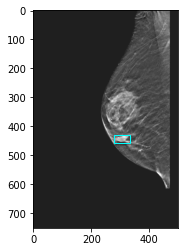

[279 431  54  26]


In [18]:
#slice_index = random.randint(0, len(up_90)-1)

plt.imshow(vol[slice_index].astype('float32'), cmap='gray')
ax    = plt.gca()

temp  = np.array([X, Y, Width, Height])/4.0#all_target[up_90[slice_index][0]]
temp = temp.astype('int')
index = 0

rect  = patches.Rectangle((temp[0], temp[1]), temp[2], temp[3], linewidth=1, edgecolor='cyan', fill = False)
ax.add_patch(rect)

plt.show()

print(temp)

107


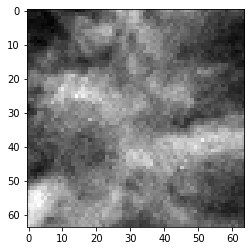

In [67]:
index = random.randint(0, len(all_lesions)-1)
print(index)
img   = all_lesions[index][8]
plt.imshow(img.astype('float32'), cmap='gray')

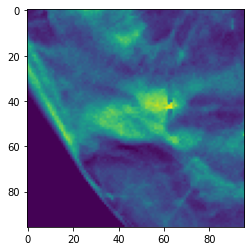

In [36]:
midx = (temp[1] + temp[1]+temp[3])//2
midy = (temp[0] + temp[0]+temp[2])//2

lesion_size = 48
lesion = vol[slice_index+8, midx-lesion_size:midx+lesion_size, midy-lesion_size:midy+lesion_size]
plt.imshow(lesion.astype('float32'))

In [63]:
# [STAR] DBT Dataset and Model Creation ResNet50

def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    #return torch.utils.data.dataloader.default_collate(batch)
    return tuple(zip(*batch))

train_dataset     = DBTDataset(train_set=1)
valid_dataset     = DBTDataset(train_set=0)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=6,
    shuffle=True,
    num_workers=0, collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0, collate_fn=collate_fn
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
model       = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, trainable_backbone_layers=2)
#model       = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
#model       = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

params       = [p for p in model.parameters() if p.requires_grad]
#optimizer    = torch.optim.Adam(params, lr=0.0001, weight_decay=0.0001)
optimizer    = torch.optim.RMSprop(params, lr=0.00001, weight_decay=0.001)
lmbda        = lambda epoch: 0.95
lr_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

#lr_scheduler = None

READING NEW FILE >>    <<
Train size are  (175, 750, 500) (175, 750, 500) (175, 750, 500) (175,)
Total size of dataset  (525, 750, 500)
READING NEW FILE >>    <<
Train size are  (49, 750, 500) (49, 750, 500) (49, 750, 500) (49,)
Total size of dataset  (49, 750, 500)


In [ ]:
# [STAR] Training loop for DBT dataset

# For the model fasterrcnn_resnet50_dbt25.pth gets 0.7 mean sensitivity on challenge validation trained on 175 samples
# Epoch #3 Train loss: 0.16284725290130486
# Epoch #3 Val   loss: 0.18728316101349063
# 0.18152466780609555

loss_hist    = Averager()

loss_object  = Averager()
loss_box_reg = Averager()
loss_rpn_box_reg = Averager()
loss_classifier  = Averager()

val_loss_hist    = Averager()
val_loss_object  = Averager()
val_loss_box_reg = Averager()
val_loss_rpn_box_reg = Averager()
val_loss_classifier  = Averager()

prev_min   = 1000
num_epochs = 50
itr        = 1
for epoch in range(num_epochs):
    loss_hist.reset()
    loss_object.reset()
    loss_box_reg.reset()
    loss_rpn_box_reg.reset()
    loss_classifier.reset()
        
    model.train()
    #itr = 1
    for images, targets, image_ids in train_data_loader:
        new_images  = []
        for img in images:
            new_images.append(torch.Tensor(img).to(device))
        
        images    = new_images
        targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
        #print(len(targets), targets[0]['labels'])
        loss_dict = model(images, targets)
        #print(loss_dict)
#         filter_losses = []
#         for loss_key in loss_dict:
#             if loss_key  == 'loss_objectness':
#                 filter_losses.append(loss_dict[loss_key])
#             elif loss_key  == 'loss_box_reg':
#                 filter_losses.append(loss_dict[loss_key])
#             elif loss_key  == 'loss_rpn_box_reg':
#                 filter_losses.append(loss_dict[loss_key])
        
        
        loss_object.send(loss_dict['loss_objectness'].item())
        loss_box_reg.send(loss_dict['loss_box_reg'].item())
        loss_rpn_box_reg.send(loss_dict['loss_rpn_box_reg'].item())
        loss_classifier.send(loss_dict['loss_classifier'].item())
                
        #losses = sum(filter_losses)
        #print('loss is ', loss_dict)
        losses     = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        #if itr % 50 == 0:
        #    print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
        
    if 1:#itr % 31 == 0:
        #print('itr is ', itr)
        val_loss_hist.reset()
        val_loss_object.reset()
        val_loss_box_reg.reset()
        val_loss_rpn_box_reg.reset()
        val_loss_classifier.reset()

        with torch.no_grad():
            for images, targets, image_ids in valid_data_loader:
                new_images  = []
                for img in images:
                    new_images.append(torch.Tensor(img).to(device))

                images    = new_images
                targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
                loss_dict = model(images, targets)

                #print(loss_dict)

#                     filter_losses = []
#                     for loss_key in loss_dict:
#                         if loss_key  == 'loss_objectness':
#                             filter_losses.append(loss_dict[loss_key])
#                         elif loss_key  == 'loss_box_reg':
#                             filter_losses.append(loss_dict[loss_key])
#                         elif loss_key  == 'loss_rpn_box_reg':
#                             filter_losses.append(loss_dict[loss_key])

                #losses = sum(filter_losses)
                losses     = sum(loss for loss in loss_dict.values())
                loss_value = losses.item()

                val_loss_hist.send(loss_value)
                val_loss_object.send(loss_dict['loss_objectness'].item())
                val_loss_box_reg.send(loss_dict['loss_box_reg'].item())
                val_loss_rpn_box_reg.send(loss_dict['loss_rpn_box_reg'].item())
                val_loss_classifier.send(loss_dict['loss_classifier'].item())

#                 if val_loss_hist.value < prev_min:
#                     #print(f"Epoch #{epoch} Train loss: {loss_hist.value}")
#                     print(f"Epoch #{epoch} Val   loss: {round(val_loss_hist.value, 5)} {round(val_loss_object.value, 5)} {round(val_loss_rpn_box_reg.value, 5)} {round(val_loss_box_reg.value, 5)} {round(val_loss_classifier.value, 5)}")
#                     #print(f"Epoch #{epoch}  ")
#                     #print('Saving the model ', prev_min, val_loss_hist.value)
#                     #torch.save(model.state_dict(), 'fasterrcnn_resnet50_dbt30_'+str(epoch)+'.pth')
#                     prev_min = val_loss_hist.value
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    
    torch.save(model.state_dict(), 'fasterrcnn_resnet50_dbt41_'+str(epoch)+'.pth')
    print(f"Epoch #{epoch} Train loss: {round(loss_hist.value, 5)} {round(loss_object.value, 5)} {round(loss_box_reg.value, 5)} {round(loss_rpn_box_reg.value, 5)} {round(loss_classifier.value, 5)}")
    print(f"Epoch #{epoch} Val   loss: {round(val_loss_hist.value, 5)} {round(val_loss_object.value, 5)} {round(val_loss_rpn_box_reg.value, 5)} {round(val_loss_box_reg.value, 5)} {round(val_loss_classifier.value, 5)}")
    
#     if val_loss_hist.value < prev_min:
#         print('Saving the model ', prev_min, val_loss_hist.value)
#         torch.save(model.state_dict(), 'fasterrcnn_resnet50_dbt26.pth')
#         prev_min = val_loss_hist.value

In [ ]:
# [STAR] For printing the loss of the trained model

# fasterrcnn_resnet50_dbt7.pth  0.24080992616713048
# fasterrcnn_resnet50_dbt8.pth  0.1653416310250759
# fasterrcnn_resnet50_dbt9.pth  0.17630461007356643
# fasterrcnn_resnet50_dbt10.pth 0.17438715264201166
# fasterrcnn_resnet50_dbt11.pth 0.16590506657958032
# fasterrcnn_resnet50_dbt14.pth 0.1608045955002308
# fasterrcnn_resnet50_dbt21.pth 0.15965028703212739
# fasterrcnn_resnet50_dbt15.pth (3 adjacent channel)

all_target    = []
all_scores    = []
val_loss_hist = Averager()
val_loss_hist = Averager()
val_loss_object  = Averager()
val_loss_box_reg = Averager()
val_loss_rpn_box_reg = Averager()
val_loss_classifier  = Averager()

itr = 1

#device = torch.device("cpu")
#model.to(device)
model.load_state_dict(torch.load('fasterrcnn_resnet50_dbt33_14.pth'))
model.train()

with torch.no_grad():
    for images, targets, image_ids in valid_data_loader:
        new_images  = []
        for img in images:
            new_images.append(torch.Tensor(img).to(device))

        images    = new_images
        targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        #print(loss_dict)
        
#         filter_losses = []
#         for loss_key in loss_dict:
#             if loss_key    == 'loss_objectness':
#                 filter_losses.append(loss_dict[loss_key])
#             elif loss_key  == 'loss_box_reg':
#                 filter_losses.append(loss_dict[loss_key])
#             elif loss_key  == 'loss_rpn_box_reg':
#                 filter_losses.append(loss_dict[loss_key])
        
#         losses = sum(filter_losses)
        losses     = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        
        val_loss_hist.send(loss_value)
        val_loss_object.send(loss_dict['loss_objectness'].item())
        val_loss_box_reg.send(loss_dict['loss_box_reg'].item())
        val_loss_rpn_box_reg.send(loss_dict['loss_rpn_box_reg'].item())
        val_loss_classifier.send(loss_dict['loss_classifier'].item())
                    
        if itr % 10 == 0:
            print(f"Epoch #{epoch} Val   loss: {round(val_loss_hist.value, 5)} {round(val_loss_object.value, 5)} {round(val_loss_rpn_box_reg.value, 5)} {round(val_loss_box_reg.value, 5)} {round(val_loss_classifier.value, 5)}")
            #print(f"Validation Iteration #{itr} loss: {loss_value}")
        itr = itr+1

print(val_loss_hist.value)

In [ ]:
# [STAR] For Obtaining the result (MobileNet) on Validation set of the Challenge

def collate_fn(batch):
    return tuple(zip(*batch))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2


# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone.out_channels = 1280

anchor_generator = AnchorGenerator(sizes=((32, 64, 128),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=14,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

model.to(device)
#model.load_state_dict(torch.load('fasterrcnn_resnet50_dbt25.pth'))
model.load_state_dict(torch.load('fasterrcnn_resnet50_dbt29.pth'))
model.eval()


trainx = []
trainy = []
boximage  = []
coordx =  []
coordy = []

width_arr  = []
height_arr = []

PatientID_arr = []
StudyUID_arr  = []

#device = torch.device("cpu")
#model.to(device)


import pickle

#shuffle_index = np.load('shuffle_array.npy')
#shuffle_index = shuffle_index[150:]
        
basepath = '/home/drilnvm/DBTex/'
#df = read_boxes(boxes_fp=basepath+"BCS-DBT-boxes-train.csv", filepaths_fp=basepath+"BCS-DBT-file-paths-train.csv")
#df = pd.read_csv(basepath+"BCS-DBT-file-paths-train.csv")
df = pd.read_csv(basepath+"BCS-DBT-boxes-train.csv")

#for i in tqdm(range(0, len(df))):
#for i in tqdm(range(0, 49)):
for i in tqdm(range(175, 224)):
    #if i in shuffle_index:
    
    #else:
    #    continue
    box_series  = df.iloc[i]
    PatientID   = box_series["PatientID"]
    StudyUID    = box_series["StudyUID"]
    view        = box_series["View"]
    
    print('Processing ', i, PatientID, StudyUID, view)
    
    #slice_index = box_series["Slice"]
    #image_path  = os.path.join(basepath, box_series["descriptive_path"])
    #print(box_series)
    
    valid_dataset     = DBTDatasetValidationTrain(val_index=i)
    #valid_dataset     = DBTDataset(train_set=0)
    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=0, 
        collate_fn=collate_fn
    )
        
    all_target = []
    all_scores = []
    all_images = []
    
    for images, targets, image_ids in valid_data_loader:
        #print(targets)
        all_images.append(images[0][0].astype('float16'))
        new_images  = []
        for img in images:
            new_images.append(torch.Tensor(img).to(device))

        images    = new_images
        #targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model.forward(images)
        #print(loss_dict)
        
        
        all_scores.append(loss_dict[0]['scores'].data.cpu().numpy())
        all_target.append(loss_dict[0]['boxes'].data.cpu().numpy())
    
    with open('/media/drilnvm/ubuntudata2/DBTEx_results29_validation/'+PatientID+'_'+StudyUID+'_'+view+'_score.data', 'wb') as filehandle:
        # store the data as binary data stream
        pickle.dump(all_scores, filehandle)
        
    with open('/media/drilnvm/ubuntudata2/DBTEx_results29_validation/'+PatientID+'_'+StudyUID+'_'+view+'_target.data', 'wb') as filehandle:
        # store the data as binary data stream
        pickle.dump(all_target, filehandle)
    
    #np.save('/media/drilnvm/ubuntudata2/DBTEx_numpy2/val_vol_'+str(i), np.array(all_images).astype('float16'))

In [ ]:
# [STAR] For Obtaining the result (ResNet) on Validation set of the Challenge

def collate_fn(batch):
    return tuple(zip(*batch))

device      = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
model       = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)
#model.load_state_dict(torch.load('fasterrcnn_resnet50_dbt25.pth'))
model.load_state_dict(torch.load('fasterrcnn_resnet50_dbt40_4.pth'))
model.eval()


trainx = []
trainy = []
boximage  = []
coordx =  []
coordy = []

width_arr  = []
height_arr = []

PatientID_arr = []
StudyUID_arr  = []

#device = torch.device("cpu")
#model.to(device)


import pickle

#shuffle_index = np.load('shuffle_array.npy')
#shuffle_index = shuffle_index[150:]
        
basepath = '/home/drilnvm/DBTex/'
#df = read_boxes(boxes_fp=basepath+"BCS-DBT-boxes-train.csv", filepaths_fp=basepath+"BCS-DBT-file-paths-train.csv")
df = pd.read_csv(basepath+"BCS-DBT-file-paths-test.csv")
#df = pd.read_csv(basepath+"BCS-DBT-boxes-train.csv")

for i in tqdm(range(0, len(df))):
#for i in tqdm(range(0, 49)):
#for i in tqdm(range(175, 224)):
    #if i in shuffle_index:
    
    #else:
    #    continue
    box_series  = df.iloc[i]
    PatientID   = box_series["PatientID"]
    StudyUID    = box_series["StudyUID"]
    view        = box_series["View"]
    
    print('Processing ', i, PatientID, StudyUID, view)
    
    #slice_index = box_series["Slice"]
    #image_path  = os.path.join(basepath, box_series["descriptive_path"])
    #print(box_series)
    
    valid_dataset     = DBTDatasetValidationTrain(val_index=i)
    #valid_dataset     = DBTDataset(train_set=0)
    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=0, 
        collate_fn=collate_fn
    )
        
    all_target = []
    all_scores = []
    all_images = []
    
    for images, targets, image_ids in valid_data_loader:
        #print(targets)
        all_images.append(images[0][0].astype('float16'))
        new_images  = []
        for img in images:
            new_images.append(torch.Tensor(img).to(device))

        images    = new_images
        #targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model.forward(images)
        #print(loss_dict)
        
        all_scores.append(loss_dict[0]['scores'].data.cpu().numpy())
        all_target.append(loss_dict[0]['boxes'].data.cpu().numpy())
    
    with open('/media/drilnvm/ubuntudata2/DBTEx_results40_4_validation/'+PatientID+'_'+StudyUID+'_'+view+'_score.data', 'wb') as filehandle:
        # store the data as binary data stream
        pickle.dump(all_scores, filehandle)
    
    with open('/media/drilnvm/ubuntudata2/DBTEx_results40_4_validation/'+PatientID+'_'+StudyUID+'_'+view+'_target.data', 'wb') as filehandle:
        # store the data as binary data stream
        pickle.dump(all_target, filehandle)
    
    #np.save('/media/drilnvm/ubuntudata2/DBTEx_numpy2/val_vol_'+str(i), np.array(all_images).astype('float16'))

In [ ]:
# [STAR] For creating additional samples for further training the network

prob_thresh = 0.87
df = pd.read_csv(basepath+"BCS-DBT-labels-train.csv")

trainx_add = []
trainy_add = []
coordx_add = []
coordy_add = []
width_arr_add  = []
height_arr_add = []


for i in range(len(df)):    
    PatientID  = df.iloc[i].PatientID
    StudyUID   = df.iloc[i].StudyUID
    view_name  = df.iloc[i].View
    if df.iloc[i].Normal != 1:
        continue
    
    case_index = i
    #print(case_index, PatientID, StudyUID, view_name, df.iloc[i].Normal)
    
    all_target = pickle.load(open('/media/drilnvm/ubuntudata2/DBTEx_results27H_validation/'+PatientID+'_'+StudyUID+'_'+view_name+'_target.data', 'rb'))
    all_scores = pickle.load(open('/media/drilnvm/ubuntudata2/DBTEx_results27H_validation/'+PatientID+'_'+StudyUID+'_'+view_name+'_score.data', 'rb'))

    up_90 = []
    for ik, k in enumerate(all_scores):
        if len(k) > 0 and k[0] > prob_thresh:
            up_90.append((ik, k[0]))
    
    if len(up_90) > 0:
        vol   = np.load('/media/drilnvm/ubuntudata2/DBTEx_numpy/'+PatientID+'_'+StudyUID+'_'+view_name+'.npy')
        
        for slice_index in range(len(up_90)):
            temp  = all_target[up_90[slice_index][0]]
            index = 0
            
            trainx_add.append(vol[up_90[slice_index][0]])
            coordx_add.append(temp[index][0])
            coordy_add.append(temp[index][1])
            width_arr_add.append(temp[index][2]-temp[index][0])
            height_arr_add.append(temp[index][3]-temp[index][1])
    
    print(i, len(trainx_add))

In [ ]:
#[TEMP]
normal_count = 0
up_90_count  = 0

df = pd.read_csv(basepath+"BCS-DBT-labels-train.csv")
for i in range(len(df)):
    if df.iloc[i].Normal == 1:
        normal_count = normal_count+1
        
        PatientID  = df.iloc[i].PatientID
        StudyUID   = df.iloc[i].StudyUID
        view_name  = df.iloc[i].View
        case_index = i
        
        all_target = pickle.load(open('/media/drilnvm/ubuntudata2/DBTEx_results25_validation/'+PatientID+'_'+StudyUID+'_'+view_name+'_target_'+str(case_index)+'.data', 'rb'))
        all_scores = pickle.load(open('/media/drilnvm/ubuntudata2/DBTEx_results25_validation/'+PatientID+'_'+StudyUID+'_'+view_name+'_score_'+str(case_index)+'.data', 'rb'))
        
        up_90 = []
        for ik, k in enumerate(all_scores):
            if len(k) > 0 and k[0] > 0.9:
                up_90.append((ik, k[0]))
        #if len(up_90):
        #    print(up_90)
        up_90_count = up_90_count+len(up_90)
        if len(up_90) > 0:
            print(i, df.iloc[i].PatientID, df.iloc[i].StudyUID, df.iloc[i].View, df.iloc[i].Normal, len(up_90))
        #print(len(all_target), len(all_scores))
    
print('Normal count is ', normal_count, up_90_count)

In [ ]:
# [STAR] For plotting the result for a given volume

df = pd.read_csv(basepath+"BCS-DBT-labels-train.csv")

if 0:
    while(True):    
        i  = random.randint(0, len(df))
        PatientID  = df.iloc[i].PatientID
        StudyUID   = df.iloc[i].StudyUID
        view_name  = df.iloc[i].View
        if df.iloc[i].Normal:
            break

case_index = i
print(case_index, PatientID, StudyUID, view_name, df.iloc[i].Normal)
vol = np.load('/media/drilnvm/ubuntudata2/DBTEx_numpy/'+PatientID+'_'+StudyUID+'_'+view_name+'.npy')
#print(vol.shape)

all_target = pickle.load(open('/media/drilnvm/ubuntudata2/DBTEx_results27H_validation/'+PatientID+'_'+StudyUID+'_'+view_name+'_target.data', 'rb'))
all_scores = pickle.load(open('/media/drilnvm/ubuntudata2/DBTEx_results27H_validation/'+PatientID+'_'+StudyUID+'_'+view_name+'_score.data', 'rb'))

print(vol.shape, len(all_target), len(all_scores))

up_90 = []
for ik, k in enumerate(all_scores):
    if len(k) > 0 and k[0] > 0.7:
        up_90.append((ik, k[0]))

img         = vol.astype('float32')

print(len(up_90), up_90)

plt.figure(figsize=(15,7))
if len(up_90) > 0:
    slice_index = random.randint(0, len(up_90)-1)

    print(up_90[slice_index])
    plt.imshow(img[up_90[slice_index][0]], cmap='gray')
    ax    = plt.gca()

    temp  = all_target[up_90[slice_index][0]]
    index = 0

    rect  = patches.Rectangle((temp[index][0], temp[index][1]), temp[index][2]-temp[index][0], temp[index][3]-temp[index][1], linewidth=1, edgecolor='cyan', fill = False)
    ax.add_patch(rect)

    plt.show()
else:
    print("Not found ")

In [184]:
# [STAR] For writing the csv file for submission

foldername= 'DBTEx_results35_14_validation'

from scipy.signal import find_peaks

total_prediction = ["PatientID,StudyUID,View,X,Width,Y,Height,Z,Depth,Score"]
prediction_lines = []

df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-file-paths-test.csv')
#df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-file-paths-train.csv')
#df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-boxes-train.csv')
print('Total length ', len(df))

#shuffle_index = np.load('shuffle_array.npy')
#shuffle_index = shuffle_index[150:]

all1_array      = []
all_peaks_array = []
names_array     = []

def smooth(y, box_pts):
    box      = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

error_count = 0

#for case_index in range(175, 224):
#for case_index in range(0, 49):
for case_index in range(len(df)):
    #if case_index not in shuffle_index:
    #    continue
    
    box_series  = df.iloc[case_index]
    PatientID   = box_series["PatientID"]
    StudyUID    = box_series["StudyUID"]
    view_name   = box_series["View"]
    
    names_array.append(PatientID+'_'+StudyUID+'_'+view_name)
    #img        = np.load('/media/drilnvm/ubuntudata2/DBTEx_numpy1/val_vol_'+str(case_index)+'.npy')
    all_target = pickle.load(open('/media/drilnvm/ubuntudata2/'+foldername+'/'+PatientID+'_'+StudyUID+'_'+view_name+'_target.data', 'rb'))
    all_scores = pickle.load(open('/media/drilnvm/ubuntudata2/'+foldername+'/'+PatientID+'_'+StudyUID+'_'+view_name+'_score.data', 'rb'))
    
    print(len(all_target))
    print(len(all_scores))
    print('--------------------------')
    #print(PatientID, StudyUID, view_name,  len(all_target), len(all_scores))
    
    d_init_x = -1
    d_init_y = -1
    d_init_z = -1
    all1     = []
    
    for i, t in enumerate(all_scores):
        if len(t) > 0:# and t[0] > 0.05:
            if d_init_x == -1:
                d_init_x = all_target[i][0][0]
                d_init_y = all_target[i][0][1]
                d_init_z = i
            
            temp_dist = np.linalg.norm([all_target[i][0][0]-d_init_x, all_target[i][0][1]-d_init_y, i-d_init_z])
            #all1.append(temp_dist)
            if temp_dist < 10:
                all1.append(all_scores[i][0])
            else:
                all1.append(0)
            
            # update previous coordinate
            d_init_x = all_target[i][0][0]
            d_init_y = all_target[i][0][1]
            d_init_z = i
        else:
            all1.append(0)
    
    #all1     = 1-np.array(all1)
    all1     = np.array(all1)
    all1     = smooth(all1, 3)
    #all1[all1 < 0.3] = 0
    #peaks, _ = find_peaks(all1, width=2)
    peaks, _ = find_peaks(all1)#, distance=4)
    
    all1_array.append(all1)
    all_peaks_array.append(peaks)
    
    #peaks, _ = find_peaks(all1, distance=4, plateau_size=4)
    
    volume_predictions = []
    for p in peaks:
        if len(all_target[p]) == 0:
            if len(all_target[p-1]) > 0 or len(all_target[p+1]) > 0:
                if len(all_target[p-1]) > 0:
                    p = p-1
                elif len(all_target[p+1]) > 0:
                    p = p+1
            else:
                error_count = error_count+1
                continue
            #print('Some Error')
            #print(all_target[p])
            #print(all_scores[p])
            #error_count+1
            #if len(all_target[p+1]) > 0:
            #p = p-1
            #continue
        #else:
            
        
        #if all_scores[p][0] < 0.65:
        #    continue
        
        #if all1[p+1]
        temp = all_target[p][0]*4
        #result_string = [PatientID, StudyUID, view_name, int(temp[0]), int(temp[2]- temp[0]), int(temp[1]), int(temp[3]-temp[1]), p, 8, all_scores[p][0]]
        # for getting the subtracted center
        result_string = [PatientID, StudyUID, view_name, int(temp[0]), int(temp[2]- temp[0]), int(temp[1]), int(temp[3]-temp[1]), np.max([p-4, 0]), 8, all_scores[p][0]]
        result_string = [str(x) for x in result_string]
        #result_string = ",".join(result_string)
        
        width  = int(temp[2]- temp[0])
        height = int(temp[3]-temp[1])
        area   = width*height
        
        if area > 100:
            volume_predictions.append(result_string)
        #print(PatientID, StudyUID, view_name, temp, all_scores[p][0])
        #print(PatientID, StudyUID, view_name, int(temp[0]), int(temp[2]- temp[0]), int(temp[1]), int(temp[3]-temp[1]))
        #print(result_string)
    
    
    # For sorting by confidence score
    #volume_predictions = sorted(volume_predictions, key=lambda x: x[-1])
    #if len(volume_predictions) > 6:
    #    volume_predictions = volume_predictions[-6:]
    
    print('-------------------')
    for result_string in volume_predictions:
        result_string = ",".join(result_string)
        print(result_string)
        total_prediction.append(result_string)
    print(PatientID, StudyUID, view_name, len(volume_predictions))
    # For second predictions in target
    if 0:
        d_init_x = -1
        d_init_y = -1
        d_init_z = -1
        all1     = []
    
        for i, t in enumerate(all_scores):
            if len(t) > 1 and t[1] > 0.35:
                if d_init_x == -1:
                    d_init_x = all_target[i][1][0]
                    d_init_y = all_target[i][1][1]
                    d_init_z = i

                temp_dist = np.min([100, np.linalg.norm([all_target[i][0][0]-d_init_x, all_target[i][0][1]-d_init_y, i-d_init_z])])
                all1.append(temp_dist)

                # update previous coordinate
                d_init_x = all_target[i][1][0]
                d_init_y = all_target[i][1][1]
                d_init_z = i
            else:
                all1.append(100)
    
        all1     = 100-np.array(all1)
        peaks, _ = find_peaks(all1, distance=4, width=3)

        #all1_array.append(all1)
        #all_peaks_array.append(peaks)

        #peaks, _ = find_peaks(all1, distance=4, plateau_size=4)

        for p in peaks:
            temp = all_target[p][1]*4
            #result_string = [PatientID, StudyUID, view_name, int(temp[0]), int(temp[2]- temp[0]), int(temp[1]), int(temp[3]-temp[1]), p, 8, all_scores[p][0]]
            # for getting the subtracted center
            result_string = [PatientID, StudyUID, view_name, int(temp[0]), int(temp[2]- temp[0]), int(temp[1]), int(temp[3]-temp[1]), np.max(p-4, 0), 8, all_scores[p][0]]
            result_string = [str(x) for x in result_string]
            result_string = ",".join(result_string)

            #print(PatientID, StudyUID, view_name, temp, all_scores[p][0])
            #print(PatientID, StudyUID, view_name, int(temp[0]), int(temp[2]- temp[0]), int(temp[1]), int(temp[3]-temp[1]))
            print(result_string)
            total_prediction.append(result_string)
    
print('Total Error count ', error_count)
print('Total Prediction ', len(total_prediction))
total_prediction = "\n".join(total_prediction)

#text_file = open("DBTEx_results26_validation_submit1_35_3_subtract.csv", "w")
text_file = open("result_6.csv", "w")
text_file.write(total_prediction)
text_file.close()


#plt.plot(all1)
#plt.plot(peaks, all1[peaks], 'x')

Total length  601
56
56
--------------------------
-------------------
DBT-P00036,DBT-S03354,lcc,238,178,1135,172,0,8,0.18533361
DBT-P00036,DBT-S03354,lcc,435,192,1083,150,4,8,0.30579373
DBT-P00036,DBT-S03354,lcc,687,201,800,207,9,8,0.5100151
DBT-P00036,DBT-S03354,lcc,518,322,817,261,21,8,0.5043375
DBT-P00036,DBT-S03354,lcc,302,388,661,230,33,8,0.098845124
DBT-P00036,DBT-S03354,lcc,602,126,773,76,38,8,0.075020105
DBT-P00036 DBT-S03354 lcc 6
62
62
--------------------------
-------------------
DBT-P00036,DBT-S03354,lmlo,38,162,154,240,1,8,0.36250815
DBT-P00036,DBT-S03354,lmlo,758,354,1298,329,15,8,0.9137951
DBT-P00036,DBT-S03354,lmlo,768,307,1320,268,17,8,0.92145526
DBT-P00036,DBT-S03354,lmlo,208,190,1569,159,32,8,0.6804836
DBT-P00036,DBT-S03354,lmlo,216,166,1575,136,37,8,0.59317183
DBT-P00036,DBT-S03354,lmlo,561,374,2000,281,47,8,0.41540566
DBT-P00036,DBT-S03354,lmlo,553,375,1968,336,49,8,0.45894682
DBT-P00036 DBT-S03354 lmlo 7
55
55
--------------------------
-------------------
DBT-P

57
57
--------------------------
-------------------
DBT-P00387,DBT-S02567,rcc,648,494,936,531,0,8,0.8529947
DBT-P00387,DBT-S02567,rcc,1623,284,860,296,2,8,0.44557303
DBT-P00387,DBT-S02567,rcc,1544,386,824,373,6,8,0.5345756
DBT-P00387,DBT-S02567,rcc,998,93,882,87,8,8,0.618436
DBT-P00387,DBT-S02567,rcc,1531,407,802,393,14,8,0.92722464
DBT-P00387,DBT-S02567,rcc,1539,395,838,379,26,8,0.9800954
DBT-P00387,DBT-S02567,rcc,1639,265,886,285,35,8,0.94646156
DBT-P00387,DBT-S02567,rcc,1628,271,879,320,41,8,0.8746136
DBT-P00387,DBT-S02567,rcc,1561,377,852,355,47,8,0.8059955
DBT-P00387 DBT-S02567 rcc 9
62
62
--------------------------
-------------------
DBT-P00387,DBT-S02567,rmlo,877,375,1227,377,5,8,0.97050357
DBT-P00387,DBT-S02567,rmlo,885,375,1283,301,10,8,0.9647748
DBT-P00387,DBT-S02567,rmlo,912,101,1133,99,14,8,0.8375303
DBT-P00387,DBT-S02567,rmlo,1299,289,267,268,24,8,0.98523223
DBT-P00387,DBT-S02567,rmlo,1294,310,264,275,29,8,0.98293936
DBT-P00387,DBT-S02567,rmlo,1312,290,274,268,41,8,0.909

39
39
--------------------------
-------------------
DBT-P00989,DBT-S02187,rcc,846,205,1720,189,0,8,0.5232941
DBT-P00989,DBT-S02187,rcc,598,98,1472,117,6,8,0.5023272
DBT-P00989,DBT-S02187,rcc,1246,155,1521,120,11,8,0.90510976
DBT-P00989,DBT-S02187,rcc,1559,181,776,178,21,8,0.46737996
DBT-P00989,DBT-S02187,rcc,1555,190,777,181,25,8,0.59280133
DBT-P00989,DBT-S02187,rcc,1549,200,772,188,33,8,0.28060925
DBT-P00989 DBT-S02187 rcc 6
46
46
--------------------------
-------------------
DBT-P00989,DBT-S02187,rmlo,1206,202,434,213,1,8,0.572735
DBT-P00989,DBT-S02187,rmlo,1855,144,79,194,9,8,0.9185166
DBT-P00989,DBT-S02187,rmlo,1257,140,1694,131,12,8,0.91403806
DBT-P00989,DBT-S02187,rmlo,1858,141,86,181,14,8,0.92415595
DBT-P00989,DBT-S02187,rmlo,1861,138,91,173,17,8,0.9151355
DBT-P00989,DBT-S02187,rmlo,1845,154,78,208,26,8,0.7005088
DBT-P00989,DBT-S02187,rmlo,1011,204,590,166,28,8,0.59422594
DBT-P00989,DBT-S02187,rmlo,1017,195,588,162,30,8,0.5097242
DBT-P00989,DBT-S02187,rmlo,1025,179,589,153,36,

-------------------
DBT-P01782,DBT-S02741,lmlo,9,224,1501,369,1,8,0.22610454
DBT-P01782,DBT-S02741,lmlo,268,610,1333,499,4,8,0.09594021
DBT-P01782,DBT-S02741,lmlo,520,137,1231,104,8,8,0.15623577
DBT-P01782,DBT-S02741,lmlo,549,189,2000,178,14,8,0.34904328
DBT-P01782,DBT-S02741,lmlo,152,314,1407,262,19,8,0.08730922
DBT-P01782,DBT-S02741,lmlo,221,292,1319,343,27,8,0.16172166
DBT-P01782,DBT-S02741,lmlo,0,89,352,161,30,8,0.32678452
DBT-P01782,DBT-S02741,lmlo,0,245,979,403,35,8,0.44595423
DBT-P01782,DBT-S02741,lmlo,291,339,1295,319,39,8,0.07231837
DBT-P01782,DBT-S02741,lmlo,113,686,1240,598,47,8,0.073786676
DBT-P01782,DBT-S02741,lmlo,271,544,1284,536,53,8,0.4594449
DBT-P01782,DBT-S02741,lmlo,277,573,1250,559,58,8,0.058694523
DBT-P01782,DBT-S02741,lmlo,293,234,1900,242,69,8,0.069406636
DBT-P01782 DBT-S02741 lmlo 13
64
64
--------------------------
-------------------
DBT-P01782,DBT-S02741,rcc,994,302,1334,401,1,8,0.77713007
DBT-P01782,DBT-S02741,rcc,1001,312,1358,294,6,8,0.82510847
DBT-P01782

-------------------
DBT-P02651,DBT-S03170,lcc,47,182,1474,230,3,8,0.55833787
DBT-P02651,DBT-S03170,lcc,296,386,975,389,12,8,0.9588547
DBT-P02651,DBT-S03170,lcc,289,391,976,411,17,8,0.94848275
DBT-P02651,DBT-S03170,lcc,35,272,1435,328,23,8,0.6637227
DBT-P02651,DBT-S03170,lcc,3,296,1430,338,31,8,0.89358455
DBT-P02651,DBT-S03170,lcc,14,269,1450,312,35,8,0.663729
DBT-P02651,DBT-S03170,lcc,230,355,913,392,47,8,0.933087
DBT-P02651,DBT-S03170,lcc,266,319,918,381,52,8,0.5620585
DBT-P02651,DBT-S03170,lcc,290,305,909,358,54,8,0.10688275
DBT-P02651,DBT-S03170,lcc,417,123,1432,110,63,8,0.5639632
DBT-P02651 DBT-S03170 lcc 10
75
75
--------------------------
-------------------
DBT-P02651,DBT-S03170,lmlo,493,317,1138,410,0,8,0.6326115
DBT-P02651,DBT-S03170,lmlo,582,82,727,82,1,8,0.6339759
DBT-P02651,DBT-S03170,lmlo,577,85,721,93,6,8,0.77765113
DBT-P02651,DBT-S03170,lmlo,20,269,1659,402,13,8,0.25755018
DBT-P02651,DBT-S03170,lmlo,16,275,1685,378,15,8,0.27077222
DBT-P02651,DBT-S03170,lmlo,319,358,1330,

-------------------
DBT-P03536,DBT-S02506,rmlo,1151,715,1217,731,1,8,0.05786545
DBT-P03536,DBT-S02506,rmlo,1143,607,1039,652,7,8,0.40891778
DBT-P03536,DBT-S02506,rmlo,1154,627,1073,686,15,8,0.78076565
DBT-P03536,DBT-S02506,rmlo,1314,343,588,397,17,8,0.79516476
DBT-P03536,DBT-S02506,rmlo,1204,555,1058,695,26,8,0.92931944
DBT-P03536,DBT-S02506,rmlo,1193,531,1048,697,32,8,0.88410354
DBT-P03536,DBT-S02506,rmlo,1210,543,1137,653,36,8,0.86063117
DBT-P03536,DBT-S02506,rmlo,1245,419,1056,627,41,8,0.7802999
DBT-P03536,DBT-S02506,rmlo,1255,313,1114,362,49,8,0.8249144
DBT-P03536,DBT-S02506,rmlo,1286,303,1104,377,62,8,0.06537933
DBT-P03536 DBT-S02506 rmlo 10
75
75
--------------------------
-------------------
DBT-P03571,DBT-S04962,lcc,389,311,1752,295,0,8,0.07817642
DBT-P03571,DBT-S04962,lcc,608,105,1976,86,4,8,0.2546535
DBT-P03571,DBT-S04962,lcc,380,409,1694,404,8,8,0.52242404
DBT-P03571,DBT-S04962,lcc,260,168,958,154,13,8,0.11581518
DBT-P03571,DBT-S04962,lcc,289,425,791,364,24,8,0.8841372
DBT-P

-------------------
DBT-P04451,DBT-S00882,lcc,788,101,644,89,0,8,0.21689482
DBT-P04451,DBT-S00882,lcc,716,207,617,146,4,8,0.2238558
DBT-P04451,DBT-S00882,lcc,727,183,601,161,7,8,0.21276923
DBT-P04451,DBT-S00882,lcc,814,109,1640,91,15,8,0.5064809
DBT-P04451,DBT-S00882,lcc,1196,100,1517,108,22,8,0.05149357
DBT-P04451,DBT-S00882,lcc,442,98,502,99,32,8,0.25044084
DBT-P04451,DBT-S00882,lcc,452,74,500,97,38,8,0.060131464
DBT-P04451,DBT-S00882,lcc,604,79,488,87,47,8,0.23548946
DBT-P04451,DBT-S00882,lcc,568,82,1599,112,52,8,0.16269587
DBT-P04451,DBT-S00882,lcc,569,63,1623,76,57,8,0.094746605
DBT-P04451 DBT-S00882 lcc 10
92
92
--------------------------
-------------------
DBT-P04451,DBT-S00882,lmlo,120,107,1694,87,1,8,0.34286985
DBT-P04451,DBT-S00882,lmlo,88,156,1672,121,9,8,0.60583246
DBT-P04451,DBT-S00882,lmlo,134,105,1690,92,15,8,0.11291569
DBT-P04451,DBT-S00882,lmlo,845,105,2130,94,21,8,0.10617746
DBT-P04451,DBT-S00882,lmlo,779,96,1498,93,26,8,0.124845155
DBT-P04451,DBT-S00882,lmlo,848,107

In [152]:
# [STAR] For writing the csv file for submission

foldername= 'DBTEx_results35_14_validation'

from scipy.signal import find_peaks

total_prediction = ["PatientID,StudyUID,View,X,Width,Y,Height,Z,Depth,Score"]
prediction_lines = []

df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-file-paths-validation.csv')
#df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-file-paths-train.csv')
#df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-boxes-train.csv')
print('Total length ', len(df))

#shuffle_index = np.load('shuffle_array.npy')
#shuffle_index = shuffle_index[150:]

all1_array      = []
all_peaks_array = []
names_array     = []

def smooth(y, box_pts):
    box      = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

error_count = 0

#for case_index in range(175, 224):
#for case_index in range(0, 49):
for case_index in range(len(df)):
    #if case_index not in shuffle_index:
    #    continue
    
    box_series  = df.iloc[case_index]
    PatientID   = box_series["PatientID"]
    StudyUID    = box_series["StudyUID"]
    view_name   = box_series["View"]
    
    names_array.append(PatientID+'_'+StudyUID+'_'+view_name)
    
    folder_array = ['DBTEx_results40_0_validation', 'DBTEx_results40_1_validation', 'DBTEx_results40_2_validation', 'DBTEx_results40_3_validation', 'DBTEx_results40_4_validation']
    prob_map = np.zeros([len(all_target), 750, 500], dtype='float16')
    
    vol = np.load('/media/drilnvm/ubuntudata2/DBTEx_numpy/'+PatientID+'_'+StudyUID+'_'+view_name+'.npy')
    
    print(PatientID+'_'+StudyUID+'_'+view_name)
    prob_slices = {}
    for foldername in folder_array:
        print(foldername)
        all_target = pickle.load(open('/media/drilnvm/ubuntudata2/'+foldername+'/'+PatientID+'_'+StudyUID+'_'+view_name+'_target.data', 'rb'))
        all_scores = pickle.load(open('/media/drilnvm/ubuntudata2/'+foldername+'/'+PatientID+'_'+StudyUID+'_'+view_name+'_score.data', 'rb'))
    
        for i, t in enumerate(all_scores):
            if len(t) > 0:
                prob_slices[i] = 1
                d_init_x_start = int(all_target[i][0][0])
                d_init_y_start = int(all_target[i][0][1])
                d_init_x_end   = int(all_target[i][0][2])
                d_init_y_end   = int(all_target[i][0][3])

                #print(d_init_x_start, d_init_y_start, d_init_x_end, d_init_y_end)
                prob_map[i, d_init_y_start:d_init_y_end, d_init_x_start:d_init_x_end] = prob_map[i, d_init_y_start:d_init_y_end, d_init_x_start:d_init_x_end] + all_scores[i][0]
    prob_map = prob_map/5.0
        
    break

Total length  395
DBT-P00002_DBT-S03345_lcc
DBTEx_results40_0_validation
DBTEx_results40_1_validation
DBTEx_results40_2_validation
DBTEx_results40_3_validation
DBTEx_results40_4_validation


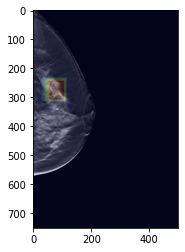

In [180]:
index = 32
plt.imshow(vol[index].astype('float32'), cmap='gray')
plt.imshow(prob_map[index].astype('float32'), alpha=0.2, cmap='jet')
#plt.hist(prob_map.flatten())

In [110]:
# [ENSEMBLE]

r0 = pd.read_csv('result_0.csv')
r1 = pd.read_csv('result_1.csv')
r2 = pd.read_csv('result_2.csv')
r3 = pd.read_csv('result_3.csv')
r4 = pd.read_csv('result_4.csv')
r5 = pd.read_csv('result_5.csv')

r_arr = [r0, r1, r2, r3, r4]
#print(len(r0), len(r1), len(r2), len(r3), len(r4), len(r5))

for i in range(0, len(r5)):
    a         = r0.iloc[i]
    
    PatientID = a.PatientID
    StudyUID  = a.StudyUID
    view      = a.View
    X = a.X
    Y = a.Y
    Z = a.Z
    Width  = a.Width
    Height = a.Height
    
    Cx = X+Width/2
    Cy = Y+Height/2
    Cz = Z
    
    temp_samples = []
    for r_temp in r_arr:
        
    prob_sum  = a.Score
    print(PatientID, StudyUID, view, X, Y, Z, Width, Height, prob_sum, prob_sum.dtype)

DBT-P00002 DBT-S03345 lcc 229 1295 9 127 99 0.056635488 float64
DBT-P00002 DBT-S03345 lcc 202 1788 17 217 155 0.27788624 float64
DBT-P00002 DBT-S03345 lcc 118 890 25 335 323 0.5238909 float64
DBT-P00002 DBT-S03345 lcc 181 1237 34 194 208 0.7914956 float64
DBT-P00002 DBT-S03345 lcc 175 1239 38 199 195 0.16662829 float64
DBT-P00002 DBT-S03345 lcc 186 1241 40 187 194 0.09039141 float64
DBT-P00002 DBT-S03345 lcc 175 1246 43 202 183 0.14055085 float64
DBT-P00002 DBT-S03345 lcc 189 1254 48 190 172 0.059556782 float64
DBT-P00002 DBT-S03345 lcc 362 1608 57 120 109 0.19004664 float64
DBT-P00002 DBT-S03345 lmlo 375 462 1 155 136 0.06687131 float64
DBT-P00002 DBT-S03345 lmlo 371 470 11 158 118 0.74162424 float64
DBT-P00002 DBT-S03345 lmlo 366 463 16 167 124 0.13130067 float64
DBT-P00002 DBT-S03345 lmlo 367 453 18 164 136 0.21756804 float64
DBT-P00002 DBT-S03345 lmlo 410 922 24 204 181 0.5283778 float64
DBT-P00002 DBT-S03345 lmlo 385 1372 30 167 173 0.3844955 float64
DBT-P00002 DBT-S03345 lmlo 0 1

DBT-P00651 DBT-S04585 rcc 1356 1762 16 126 104 0.07918463 float64
DBT-P00651 DBT-S04585 rcc 990 1724 23 137 100 0.25894612 float64
DBT-P00651 DBT-S04585 rcc 1259 1547 27 219 199 0.37655193 float64
DBT-P00651 DBT-S04585 rcc 1655 1568 36 122 103 0.56108487 float64
DBT-P00651 DBT-S04585 rmlo 1347 1580 0 224 195 0.21016003 float64
DBT-P00651 DBT-S04585 rmlo 1360 1577 2 200 187 0.8642851 float64
DBT-P00651 DBT-S04585 rmlo 1358 1590 9 177 163 0.94490075 float64
DBT-P00651 DBT-S04585 rmlo 1366 1590 13 167 165 0.9504253 float64
DBT-P00651 DBT-S04585 rmlo 1352 1581 21 199 171 0.43739197 float64
DBT-P00651 DBT-S04585 rmlo 1404 1028 25 104 96 0.6065600999999999 float64
DBT-P00651 DBT-S04585 rmlo 1374 1590 29 156 165 0.12192937 float64
DBT-P00655 DBT-S00319 rcc 1741 568 1 236 295 0.6186130999999999 float64
DBT-P00655 DBT-S00319 rcc 1738 732 6 174 123 0.62676305 float64
DBT-P00655 DBT-S00319 rcc 1730 358 17 244 232 0.18757041 float64
DBT-P00655 DBT-S00319 rcc 1322 1060 25 255 218 0.8984413 float64


DBT-P01249 DBT-S03736 rmlo 1165 804 18 257 187 0.23125035 float64
DBT-P01249 DBT-S03736 rmlo 1730 1933 25 131 313 0.13834625 float64
DBT-P01249 DBT-S03736 rmlo 1718 1930 31 140 339 0.06075959 float64
DBT-P01249 DBT-S03736 rmlo 1171 1652 37 156 168 0.8435087 float64
DBT-P01249 DBT-S03736 rmlo 1447 1304 45 87 75 0.1112306 float64
DBT-P01249 DBT-S03736 rmlo 1001 1537 52 343 290 0.6196258000000001 float64
DBT-P01249 DBT-S03736 rmlo 1321 979 57 243 236 0.5437679 float64
DBT-P01249 DBT-S03736 rmlo 1331 978 62 230 241 0.36652290000000004 float64
DBT-P01293 DBT-S04200 rcc 1330 1215 1 66 54 0.08574770400000001 float64
DBT-P01293 DBT-S04200 rcc 1204 1360 3 162 147 0.17482738 float64
DBT-P01293 DBT-S04200 rcc 1049 1654 5 165 167 0.10767262 float64
DBT-P01293 DBT-S04200 rcc 1240 1348 12 93 93 0.7847723000000001 float64
DBT-P01293 DBT-S04200 rcc 1439 1335 19 186 144 0.41423163 float64
DBT-P01293 DBT-S04200 rcc 1645 1111 23 198 171 0.7388558000000001 float64
DBT-P01293 DBT-S04200 rcc 835 1469 29 154

DBT-P01849 DBT-S03745 lcc 9 259 80 177 343 0.25861603 float64
DBT-P01849 DBT-S03745 lcc 10 238 85 168 390 0.10965135 float64
DBT-P01849 DBT-S03745 lmlo 439 1502 6 94 95 0.086089075 float64
DBT-P01849 DBT-S03745 lmlo 460 680 11 88 87 0.10743486 float64
DBT-P01849 DBT-S03745 lmlo 459 793 18 191 122 0.6932809 float64
DBT-P01849 DBT-S03745 lmlo 669 1904 30 220 205 0.66698444 float64
DBT-P01849 DBT-S03745 lmlo 0 394 34 128 149 0.49526402 float64
DBT-P01849 DBT-S03745 lmlo 0 324 42 133 205 0.43813244 float64
DBT-P01849 DBT-S03745 lmlo 824 1234 47 227 177 0.09219696 float64
DBT-P01849 DBT-S03745 lmlo 474 678 51 79 51 0.08149476 float64
DBT-P01849 DBT-S03745 lmlo 476 677 59 74 54 0.09827055 float64
DBT-P01849 DBT-S03745 lmlo 1098 920 68 109 104 0.69251573 float64
DBT-P01849 DBT-S03745 lmlo 954 923 77 240 224 0.27465559999999994 float64
DBT-P01849 DBT-S03745 lmlo 650 975 85 231 106 0.13135426 float64
DBT-P01849 DBT-S03745 rcc 1250 1851 1 130 123 0.27402765 float64
DBT-P01849 DBT-S03745 rcc 1178

DBT-P02226 DBT-S01309 rcc 772 1241 6 265 294 0.64754987 float64
DBT-P02226 DBT-S01309 rcc 762 1286 11 296 263 0.5654409 float64
DBT-P02226 DBT-S01309 rcc 1918 1459 19 81 114 0.1796359 float64
DBT-P02226 DBT-S01309 rcc 1443 744 21 100 93 0.26003200000000004 float64
DBT-P02226 DBT-S01309 rcc 1915 1454 23 84 120 0.41470164 float64
DBT-P02226 DBT-S01309 rcc 1217 1156 26 165 171 0.6354099 float64
DBT-P02226 DBT-S01309 rcc 1921 1468 33 78 93 0.41090927 float64
DBT-P02226 DBT-S01309 rcc 1923 1468 35 76 89 0.38369440000000005 float64
DBT-P02226 DBT-S01309 rcc 901 1282 38 225 194 0.59587026 float64
DBT-P02226 DBT-S01309 rcc 1641 589 43 82 80 0.23966767 float64
DBT-P02226 DBT-S01309 rcc 1644 595 49 67 61 0.05621389 float64
DBT-P02226 DBT-S01309 rmlo 913 1384 0 162 178 0.61074525 float64
DBT-P02226 DBT-S01309 rmlo 876 1569 2 261 262 0.9163425 float64
DBT-P02226 DBT-S01309 rmlo 1892 1209 10 86 87 0.33818874 float64
DBT-P02226 DBT-S01309 rmlo 1887 1206 18 94 95 0.9008676999999999 float64
DBT-P02226

DBT-P02959 DBT-S05167 lcc 847 854 24 193 143 0.6093484 float64
DBT-P02959 DBT-S05167 lcc 830 843 28 231 188 0.8895671999999999 float64
DBT-P02959 DBT-S05167 lcc 1072 1014 35 162 216 0.7818483 float64
DBT-P02959 DBT-S05167 lcc 866 852 39 168 132 0.8410463 float64
DBT-P02959 DBT-S05167 lcc 848 974 45 223 206 0.8671398000000001 float64
DBT-P02959 DBT-S05167 lcc 645 1245 56 111 81 0.101915464 float64
DBT-P02959 DBT-S05167 lcc 289 1300 61 114 112 0.13319698 float64
DBT-P02959 DBT-S05167 lcc 627 1212 71 118 102 0.054062083 float64
DBT-P02959 DBT-S05167 lmlo 379 698 1 79 72 0.50657606 float64
DBT-P02959 DBT-S05167 lmlo 380 700 6 76 77 0.66570497 float64
DBT-P02959 DBT-S05167 lmlo 635 1676 13 227 226 0.89260596 float64
DBT-P02959 DBT-S05167 lmlo 960 1774 20 190 157 0.85602856 float64
DBT-P02959 DBT-S05167 lmlo 279 627 28 158 169 0.49886194 float64
DBT-P02959 DBT-S05167 lmlo 975 1613 34 304 344 0.88785195 float64
DBT-P02959 DBT-S05167 lmlo 981 1637 39 291 335 0.8569094 float64
DBT-P02959 DBT-S0

DBT-P03403 DBT-S04944 lmlo 476 1324 57 234 260 0.7822102 float64
DBT-P03448 DBT-S05213 lcc 7 1452 14 150 148 0.5943432 float64
DBT-P03448 DBT-S05213 lmlo 51 1239 0 174 151 0.10395125 float64
DBT-P03448 DBT-S05213 lmlo 0 1839 8 104 115 0.7551396 float64
DBT-P03448 DBT-S05213 lmlo 57 1224 15 182 190 0.9044683000000001 float64
DBT-P03448 DBT-S05213 lmlo 61 1223 19 178 185 0.6063996 float64
DBT-P03448 DBT-S05213 rcc 1436 1417 0 169 201 0.5302965000000001 float64
DBT-P03448 DBT-S05213 rcc 1437 1406 1 166 213 0.45521694 float64
DBT-P03448 DBT-S05213 rcc 1442 1389 8 175 249 0.24615946 float64
DBT-P03448 DBT-S05213 rcc 1653 926 19 209 182 0.10856455 float64
DBT-P03448 DBT-S05213 rmlo 1616 1261 22 123 114 0.91746485 float64
DBT-P03448 DBT-S05213 rmlo 1611 1263 24 128 111 0.9131724 float64
DBT-P03501 DBT-S00689 lcc 0 2253 0 112 223 0.14784537 float64
DBT-P03501 DBT-S00689 lcc 0 2247 0 108 225 0.16982073 float64
DBT-P03501 DBT-S00689 lcc 312 1518 4 114 97 0.19727615 float64
DBT-P03501 DBT-S00689 

DBT-P04045 DBT-S04897 lcc 423 1165 12 130 135 0.47503403 float64
DBT-P04045 DBT-S04897 lcc 427 1167 16 123 133 0.6765675 float64
DBT-P04045 DBT-S04897 lcc 876 1221 31 120 224 0.4890137 float64
DBT-P04045 DBT-S04897 lcc 624 914 43 114 104 0.30631334 float64
DBT-P04045 DBT-S04897 lcc 630 913 52 104 101 0.07684273 float64
DBT-P04045 DBT-S04897 lmlo 599 455 0 125 104 0.5280793 float64
DBT-P04045 DBT-S04897 lmlo 588 454 5 141 117 0.8750916999999999 float64
DBT-P04045 DBT-S04897 lmlo 649 751 9 187 209 0.87718403 float64
DBT-P04045 DBT-S04897 lmlo 596 461 16 115 84 0.17990279999999997 float64
DBT-P04045 DBT-S04897 lmlo 407 1862 24 118 100 0.5072578 float64
DBT-P04045 DBT-S04897 lmlo 15 1964 35 285 227 0.09153116 float64
DBT-P04045 DBT-S04897 lmlo 37 845 40 96 104 0.39122602 float64
DBT-P04045 DBT-S04897 lmlo 261 722 45 184 190 0.24837558 float64
DBT-P04045 DBT-S04897 rcc 1802 2297 0 93 174 0.09301551400000001 float64
DBT-P04045 DBT-S04897 rcc 1402 927 44 206 174 0.57741845 float64
DBT-P04045 

DBT-P04396 DBT-S04935 rcc 1542 1016 29 291 331 0.6712956999999999 float64
DBT-P04396 DBT-S04935 rcc 1349 1172 33 173 138 0.46685879999999996 float64
DBT-P04396 DBT-S04935 rcc 1851 1012 43 129 200 0.7449564000000001 float64
DBT-P04396 DBT-S04935 rcc 1841 998 47 139 204 0.6207376 float64
DBT-P04396 DBT-S04935 rcc 1836 989 53 149 212 0.5794319 float64
DBT-P04396 DBT-S04935 rcc 1841 986 59 142 216 0.42173254 float64
DBT-P04396 DBT-S04935 rmlo 1440 1802 4 231 201 0.8725652 float64
DBT-P04396 DBT-S04935 rmlo 1374 1561 8 281 265 0.8211510000000001 float64
DBT-P04396 DBT-S04935 rmlo 1411 1820 17 258 186 0.8412656 float64
DBT-P04396 DBT-S04935 rmlo 901 1644 29 149 199 0.108360216 float64
DBT-P04396 DBT-S04935 rmlo 1176 1978 31 146 92 0.1662165 float64
DBT-P04396 DBT-S04935 rmlo 1350 1182 34 212 162 0.43241894 float64
DBT-P04396 DBT-S04935 rmlo 1365 1736 38 120 101 0.74238217 float64
DBT-P04396 DBT-S04935 rmlo 999 1762 42 212 203 0.46510726 float64
DBT-P04396 DBT-S04935 rmlo 1356 1187 45 182 159

IndexError: single positional indexer is out-of-bounds

In [86]:
# [STAR] For getting the AUC on the Train remaining split

from typing import AnyStr, BinaryIO, Dict, List, NamedTuple, Optional, Union

labels_fp = "/home/drilnvm/DBTex//BCS-DBT-labels-train.csv"
boxes_fp  = "/home/drilnvm/DBTex/BCS-DBT-boxes-train.csv"
predictions_fp = "result.csv"
#predictions_fp = "DBTEx_results26_validation_submit1_35_3_subtract.csv"

df_labels = pd.read_csv(labels_fp)
df_boxes  = pd.read_csv(boxes_fp, dtype={"Slice": float})
df_pred   = pd.read_csv(predictions_fp, dtype={"Score": float})

#df_boxes = df_boxes.iloc[shuffle_index].tail(74)
df_boxes = df_boxes.loc[175:224]
#df_boxes = df_boxes.loc[0:49]

df_labels = df_labels.reset_index().set_index(["StudyUID", "View"]).sort_index()
df_boxes  = df_boxes.reset_index().set_index(["StudyUID", "View"]).sort_index()
df_pred   = df_pred.reset_index().set_index(["StudyUID", "View"]).sort_index()

def _is_tp(
    box_pred: NamedTuple, box_true: NamedTuple, slice_offset: int, min_dist: int = 100
) -> bool:
    pred_y = box_pred.Y + box_pred.Height / 2
    pred_x = box_pred.X + box_pred.Width / 2
    pred_z = box_pred.Z + box_pred.Depth / 2
    #pred_z = box_pred.Z #+ 4 / 2
    
    true_y = box_true.Y + box_true.Height / 2
    true_x = box_true.X + box_true.Width / 2
    true_z = box_true.Slice
    
    # 2D distance between true and predicted center points
    dist = np.linalg.norm((pred_x - true_x, pred_y - true_y))
    # compute radius based on true box size
    dist_threshold = np.sqrt(box_true.Width ** 2 + box_true.Height ** 2) / 2.0
    dist_threshold = max(dist_threshold, min_dist)
    slice_diff     = np.abs(pred_z - true_z)
    
    # TP if predicted center within radius and slice within slice offset
    tp_flag = dist <= dist_threshold and slice_diff <=  slice_offset
    
    #print(pred_x, pred_y, pred_z)
    #print(true_x, true_y, true_z)
    #print(dist, dist_threshold, slice_diff, slice_offset, tp_flag)
    return tp_flag


def _distance(box_pred: NamedTuple, box_true: NamedTuple) -> float:
    pred_y = box_pred.Y + box_pred.Height / 2
    pred_x = box_pred.X + box_pred.Width / 2
    pred_z = box_pred.Z #+ box_pred.Depth / 2
    true_y = box_true.Y + box_true.Height / 2
    true_x = box_true.X + box_true.Width / 2
    true_z = box_true.Slice
    return np.linalg.norm((pred_x - true_x, pred_y - true_y, pred_z - true_z))

def _froc(
    df_pred: pd.DataFrame,
    thresholds: List[float],
    n_volumes: int,
    n_boxes: int,
    evaluation_fps: tuple,
) -> List[float]:
    tpr = []
    fps = []
    for th in sorted(thresholds, reverse=True):
        df_th = df_pred.loc[df_pred["Score"] >= th]
        df_th_unique_tp = df_th.reset_index().drop_duplicates(
            subset=["StudyUID", "View", "TP", "GTID"]
        )
        n_tps_th = float(sum(df_th_unique_tp["TP"]))
        tpr_th   = n_tps_th / n_boxes
        n_fps_th = float(len(df_th[df_th["TP"] == 0]))
        fps_th   = n_fps_th / n_volumes
        
        tpr.append(tpr_th)
        fps.append(fps_th)
        if fps_th > max(evaluation_fps):
            break
    #print('evaluation_fps ', evaluation_fps)
    #print('example is ', np.interp(evaluation_fps[0], fps, tpr))
    #print('fps is ', fps)
    #print('tpr is ', tpr)
    return [np.interp(x, fps, tpr) for x in evaluation_fps]

df_pred["TP"]   = 0
df_pred["GTID"] = -1

thresholds = [df_pred["Score"].max() + 1.0]

counter = 0
# find true positive predictions and assign detected ground truth box ID
for box_pred in df_pred.itertuples():
    #print(df_boxes.index)
    #print('---------------------')
    if box_pred.Index not in df_boxes.index:
        continue
    #box_pred.Depth = 4
    counter = counter+1
    #print(box_pred.Index)
    #print('TP found ', box_pred)
    df_boxes_view     = df_boxes.loc[[box_pred.Index]]
    #print("df_boxes.loc ", df_boxes.loc[[box_pred.Index], "Slice"].iloc[0])
    view_slice_offset = df_boxes.loc[[box_pred.Index], "Slice"].iloc[0] / 4
    
    #print(df_boxes_view)
    #print(box_pred)
    #print('---------------------------')
    tp_boxes = [
        b
        for b in df_boxes_view.itertuples()
        if _is_tp(box_pred, b, slice_offset=view_slice_offset)
    ]
    
    if len(tp_boxes) > 1:
        # find the nearest GT box
        tp_distances = [_distance(box_pred, b) for b in tp_boxes]
        tp_boxes     = [tp_boxes[np.argmin(tp_distances)]]
    
    #print('tp_boxes ', box_pred.Index)
    #print(tp_boxes)
    
    if len(tp_boxes) > 0:
        tp_i = tp_boxes[0].index
        #print('tp_i is ', tp_i)
        df_pred.loc[df_pred["index"] == box_pred.index, ("TP", "GTID")] = (1, tp_i)
        thresholds.append(box_pred.Score)


print('Total counter is ', counter, len(df_labels), len(df_boxes))
thresholds.append(df_pred["Score"].min() - 1.0)

#df_pred
#compute sensitivity at 2 FPs/volume on all cases
evaluation_fps_all = (2.0,)
tpr_all = _froc(
    df_pred=df_pred,
    thresholds=thresholds,
    n_volumes=len(df_labels),
    n_boxes=len(df_boxes),
    evaluation_fps=evaluation_fps_all,
)
result = {f"sensitivity_at_2_fps_all": tpr_all[0]}

# # compute mean sensitivity at 1, 2, 3, 4 FPs/volume on positive cases
df_pred   = df_pred[df_pred.index.isin(df_boxes.index)]
df_labels = df_labels[df_labels.index.isin(df_boxes.index)]
#evaluation_fps_positive = (1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0)
evaluation_fps_positive = (1.0, 2.0, 3.0, 4.0)
tpr_positive = _froc(
    df_pred=df_pred,
    thresholds=thresholds,
    n_volumes=len(df_labels),
    n_boxes=len(df_boxes),
    evaluation_fps=evaluation_fps_positive,
)

result.update(
    dict(
        (f"sensitivity_at_{int(x)}_fps_positive", y)
        for x, y in zip(evaluation_fps_positive, tpr_positive)
    )
)
result.update({"mean_sensitivity_positive": np.mean(tpr_positive)})

print(result)

Total counter is  272 2596 49
{'sensitivity_at_2_fps_all': 0.9387755102040817, 'sensitivity_at_1_fps_positive': 0.8809523809523809, 'sensitivity_at_2_fps_positive': 0.9297052154195011, 'sensitivity_at_3_fps_positive': 0.9387755102040817, 'sensitivity_at_4_fps_positive': 0.9387755102040817, 'mean_sensitivity_positive': 0.9220521541950114}


In [ ]:
# For plotting the loss

a = open('/home/drilnvm/log_plot').read().split('\n')[:-1]
v1 = []
v2 = []
v3 = []
v4 = []
v5 = []

t1 = []
t2 = []
t3 = []
t4 = []
t5 = []

print(len(a))
#print(a)
for i in range(len(a)):
    if 'Train' in a[i]:
        t1.append(float(a[i].split(':')[1].split()[0]))
        t2.append(float(a[i].split(':')[1].split()[1]))
        t3.append(float(a[i].split(':')[1].split()[2]))
        t4.append(float(a[i].split(':')[1].split()[3]))
        t5.append(float(a[i].split(':')[1].split()[4]))
    if 'Val' in a[i]:
        v1.append(float(a[i].split(':')[1].split()[0]))
        v2.append(float(a[i].split(':')[1].split()[1]))
        v3.append(float(a[i].split(':')[1].split()[2]))
        v4.append(float(a[i].split(':')[1].split()[3]))
        v5.append(float(a[i].split(':')[1].split()[4]))
#print(len(v1))

plt.plot(t5)
plt.plot(v5)

In [151]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [166]:
#is_2002 =  df_pred1['Score'] > 0.35
df_pred1   = pd.read_csv("/home/drilnvm/Downloads/dbt35_14_more_rotate.csv", dtype={"Score": float})
is_2002    =  df_pred1['Score'] > 0.75
df_pred2   = df_pred1[is_2002]

In [167]:
df_pred2.to_csv('dbt35_14_more_rotate_filter_75.csv', index=False)

In [ ]:
#35_14
{'sensitivity_at_2_fps_all': 0.9591836734693877, 'sensitivity_at_1_fps_positive': 0.8775510204081632, 'sensitivity_at_2_fps_positive': 0.9591836734693877, 'sensitivity_at_3_fps_positive': 0.9591836734693877, 'sensitivity_at_4_fps_positive': 0.9591836734693877, 'sensitivity_at_5_fps_positive': 0.9591836734693877, 'sensitivity_at_6_fps_positive': 0.9591836734693877, 'sensitivity_at_7_fps_positive': 0.9591836734693877, 'sensitivity_at_8_fps_positive': 0.9591836734693877, 'mean_sensitivity_positive': 0.9489795918367346}

#37_28
{'sensitivity_at_2_fps_all': 0.9183673469387755, 'sensitivity_at_1_fps_positive': 0.8775510204081632, 'sensitivity_at_2_fps_positive': 0.9183673469387755, 'sensitivity_at_3_fps_positive': 0.9183673469387755, 'sensitivity_at_4_fps_positive': 0.9183673469387755, 'sensitivity_at_5_fps_positive': 0.9183673469387755, 'sensitivity_at_6_fps_positive': 0.9183673469387755, 'sensitivity_at_7_fps_positive': 0.9183673469387755, 'sensitivity_at_8_fps_positive': 0.9183673469387755, 'mean_sensitivity_positive': 0.9132653061224489}

In [ ]:
# RMSprop
15 zoom
{'sensitivity_at_2_fps_all': 0.8775510204081632, 'sensitivity_at_1_fps_positive': 0.7142857142857143, 'sensitivity_at_2_fps_positive': 0.7959183673469388, 'sensitivity_at_3_fps_positive': 0.8163265306122449, 'sensitivity_at_4_fps_positive': 0.8163265306122449, 'sensitivity_at_5_fps_positive': 0.8367346938775511, 'sensitivity_at_6_fps_positive': 0.8367346938775511, 'sensitivity_at_7_fps_positive': 0.8775510204081632, 'sensitivity_at_8_fps_positive': 0.8775510204081632, 'mean_sensitivity_positive': 0.8214285714285714}

15 zoom
{'sensitivity_at_2_fps_all': 0.8571428571428571, 'sensitivity_at_1_fps_positive': 0.6836734693877551, 'sensitivity_at_2_fps_positive': 0.8163265306122449, 'sensitivity_at_3_fps_positive': 0.8163265306122449, 'sensitivity_at_4_fps_positive': 0.8208616780045351, 'sensitivity_at_5_fps_positive': 0.8367346938775511, 'sensitivity_at_6_fps_positive': 0.8367346938775511, 'sensitivity_at_7_fps_positive': 0.8571428571428571, 'sensitivity_at_8_fps_positive': 0.8571428571428571, 'mean_sensitivity_positive': 0.8156179138321995}

10 zoom
{'sensitivity_at_2_fps_all': 0.8571428571428571, 'sensitivity_at_1_fps_positive': 0.7278911564625851, 'sensitivity_at_2_fps_positive': 0.7795918367346938, 'sensitivity_at_3_fps_positive': 0.7959183673469388, 'sensitivity_at_4_fps_positive': 0.8173731030873889, 'sensitivity_at_5_fps_positive': 0.8367346938775511, 'sensitivity_at_6_fps_positive': 0.8571428571428571, 'sensitivity_at_7_fps_positive': 0.8571428571428571, 'sensitivity_at_8_fps_positive': 0.8571428571428571, 'mean_sensitivity_positive': 0.8161172161172161}

10
{'sensitivity_at_2_fps_all': 0.8571428571428571, 'sensitivity_at_1_fps_positive': 0.6530612244897959, 'sensitivity_at_2_fps_positive': 0.7142857142857143, 'sensitivity_at_3_fps_positive': 0.7959183673469388, 'sensitivity_at_4_fps_positive': 0.8163265306122449, 'sensitivity_at_5_fps_positive': 0.8571428571428571, 'sensitivity_at_6_fps_positive': 0.8571428571428571, 'sensitivity_at_7_fps_positive': 0.8571428571428571, 'sensitivity_at_8_fps_positive': 0.8571428571428571, 'mean_sensitivity_positive': 0.8010204081632653}


10
{'sensitivity_at_2_fps_all': 0.8571428571428571, 'sensitivity_at_1_fps_positive': 0.6020408163265306, 'sensitivity_at_2_fps_positive': 0.7346938775510204, 'sensitivity_at_3_fps_positive': 0.7755102040816326, 'sensitivity_at_4_fps_positive': 0.8321995464852607, 'sensitivity_at_5_fps_positive': 0.8367346938775511, 'sensitivity_at_6_fps_positive': 0.8387755102040817, 'sensitivity_at_7_fps_positive': 0.8571428571428571, 'sensitivity_at_8_fps_positive': 0.8571428571428571, 'mean_sensitivity_positive': 0.791780045351474}

5
{'sensitivity_at_2_fps_all': 0.8163265306122449, 'sensitivity_at_1_fps_positive': 0.6326530612244898, 'sensitivity_at_2_fps_positive': 0.6530612244897959, 'sensitivity_at_3_fps_positive': 0.7372448979591837, 'sensitivity_at_4_fps_positive': 0.7959183673469388, 'sensitivity_at_5_fps_positive': 0.7959183673469388, 'sensitivity_at_6_fps_positive': 0.8163265306122449, 'sensitivity_at_7_fps_positive': 0.8163265306122449, 'sensitivity_at_8_fps_positive': 0.8163265306122449, 'mean_sensitivity_positive': 0.7579719387755102}

5
{'sensitivity_at_2_fps_all': 0.8367346938775511, 'sensitivity_at_1_fps_positive': 0.5918367346938775, 'sensitivity_at_2_fps_positive': 0.6287657920310982, 'sensitivity_at_3_fps_positive': 0.6938775510204082, 'sensitivity_at_4_fps_positive': 0.7599611273080661, 'sensitivity_at_5_fps_positive': 0.8163265306122449, 'sensitivity_at_6_fps_positive': 0.8163265306122449, 'sensitivity_at_7_fps_positive': 0.8320964749536178, 'sensitivity_at_8_fps_positive': 0.8367346938775511, 'mean_sensitivity_positive': 0.7469906793886385}

In [ ]:
Total counter is  437 2596 49
{'sensitivity_at_2_fps_all': 0.8163265306122449, 'sensitivity_at_1_fps_positive': 0.673469387755102, 'sensitivity_at_2_fps_positive': 0.6989795918367346, 'sensitivity_at_3_fps_positive': 0.7761685319289006, 'sensitivity_at_4_fps_positive': 0.7916392363396971, 'sensitivity_at_5_fps_positive': 0.7959183673469388, 'sensitivity_at_6_fps_positive': 0.7959183673469388, 'sensitivity_at_7_fps_positive': 0.8089569160997733, 'sensitivity_at_8_fps_positive': 0.8163265306122449, 'mean_sensitivity_positive': 0.7696721161582913}

DBT-P00654_DBT-S02571_lcc
[ 4 12 24 28 32 36 44 50 54 56]


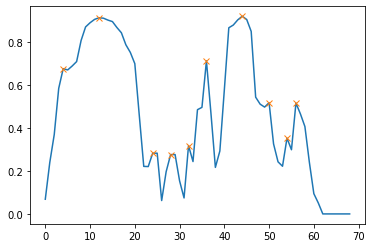

In [394]:
#index = random.randint(0, 48)
index = 27
#print(index)
print(names_array[index])
plt.plot(all1_array[index])
print(all_peaks_array[index])
plt.plot(all_peaks_array[index], all1_array[index][all_peaks_array[index]], 'x')

#print(df_boxes.iloc[index])

In [ ]:
# fasterrcnn_resnet50_dbt26
# 0.17731877538014432
# {'sensitivity_at_2_fps_all': 0.6938775510204082, 'sensitivity_at_1_fps_positive': 0.5324675324675325, 'sensitivity_at_2_fps_positive': 0.5865128660159716, 'sensitivity_at_3_fps_positive': 0.6530612244897959, 'sensitivity_at_4_fps_positive': 0.6938775510204082, 'sensitivity_at_5_fps_positive': 0.6938775510204082, 'sensitivity_at_6_fps_positive': 0.6938775510204082, 'mean_sensitivity_positive': 0.642279046005754}

# fasterrcnn_resnet50_dbt26_A
# 0.11284705700010669
#{'sensitivity_at_2_fps_all': 0.7551020408163265, 'sensitivity_at_1_fps_positive': 0.5102040816326531, 'sensitivity_at_2_fps_positive': 0.6530612244897959, 'sensitivity_at_3_fps_positive': 0.7242140099282957, 'sensitivity_at_4_fps_positive': 0.7551020408163265, 'sensitivity_at_5_fps_positive': 0.7551020408163265, 'sensitivity_at_6_fps_positive': 0.7551020408163265, 'mean_sensitivity_positive': 0.6921309064166206}

In [ ]:
# [TEMPORARY] For storing the files as numpy
import os

df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-file-paths-validation.csv')
for i in tqdm(range(97, len(df))):
    basepath    = '/home/drilnvm/DBTex/'
    box_series  = df.iloc[i]
    PatientID   = box_series["PatientID"]
    StudyUID    = box_series["StudyUID"]
    view        = box_series["View"]
        
    image_path = os.path.join(basepath, box_series["descriptive_path"])
    #vol        = dcmread_image(fp=image_path, view=view)
    #print(vol.shape)
    #newtrainx  = np.zeros([len(vol), 1, 3000, 2000], 'float16')
    #for i in range(len(vol)):
    #    newtrainx[i, 0, :vol[i].shape[0], :vol[i].shape[1]] = vol[i]
    
    #newtrain1 = []
    #for i in range(len(vol)):
    #    img          = newtrainx[i, 0].astype('float32')/60000.0
    #    img[img > 1] = 1
    #    img = ndimage.interpolation.zoom(img, 0.25).astype('float16')
    #    newtrain1.append(img)
    
    numpy_path = '/media/drilnvm/ubuntudata2/DBTEx_numpy/vol_'+str(i)+'.npy'
    #vol1       = np.load(numpy_path)
    #newtrain1 = np.array(newtrain1)
    print(PatientID, StudyUID, view)#, vol1.shape)
    #np.save('/media/drilnvm/ubuntudata2/DBTEx_numpy/'+PatientID+'_'+StudyUID+'_'+view+'.npy', newtrain1)
    temp_path = '/media/drilnvm/ubuntudata2/DBTEx_numpy/'+PatientID+'_'+StudyUID+'_'+view+'.npy'
    os.rename(numpy_path, temp_path)
    #print(i, vol.shape, vol1.shape)
        
#print(len(df))
#df.iloc[0]

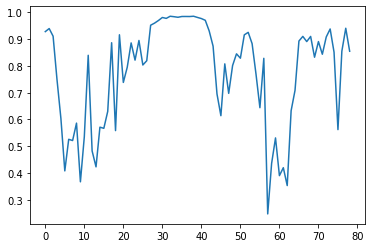

In [288]:
#plt.plot(all_scores)
a1 = []
for k in all_scores:
    if len(k) > 0:
        a1.append(k[0])
    else:
        a1.append(0)
plt.plot(a1)

In [172]:
# [STAR] For checking the predictions slice wise for the Validation set

def collate_fn(batch):
    return tuple(zip(*batch))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
model       = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)
model.load_state_dict(torch.load('fasterrcnn_resnet50_dbt26.pth'))
model.eval()

#valid_dataset     = DBTDatasetValidationTrain(val_index=i)
valid_dataset     = DBTDataset(train_set=0)
valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1, 
    collate_fn=collate_fn
)
        
all_target = []
all_scores = []
all_images = []

for images, targets, image_ids in valid_data_loader:
    all_images.append(images[0][0].astype('float16'))
    new_images  = []
    for img in images:
        new_images.append(torch.Tensor(img).to(device))

    images    = new_images
    targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
    loss_dict = model(images)
    #print(loss_dict)

    all_scores.append(loss_dict[0]['scores'].data.cpu().numpy())
    all_target.append(loss_dict[0]['boxes'].data.cpu().numpy())
        

READING NEW FILE >>    <<
Total size of dataset  224


[42]


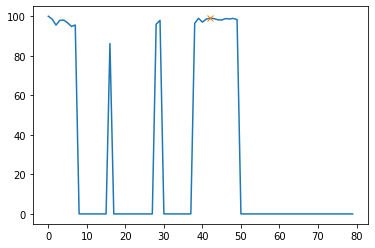

In [163]:
all1 = []
for t in all_scores:
    if len(t) > 0 and t[0] > 0.5:
        #print(t[0])
        all1.append(t[0])
    else:
        all1.append(0)


d_init_x = -1
d_init_y = -1
d_init_z = -1
all1     = []

for i, t in enumerate(all_scores):
    if len(t) > 0 and t[0] > 0.5:
        if d_init_x == -1:
            d_init_x = all_target[i][0][0]
            d_init_y = all_target[i][0][1]
            d_init_z = i
        
        temp_dist = np.min([100, np.linalg.norm([all_target[i][0][0]-d_init_x, all_target[i][0][1]-d_init_y, i-d_init_z])])
        all1.append(temp_dist)
        d_init_x = all_target[i][0][0]
        d_init_y = all_target[i][0][1]
        d_init_z = i
    else:
        all1.append(100)
all1 = 100-np.array(all1)

from scipy.signal import find_peaks

peaks, _ = find_peaks(all1, distance=8, width=4)
#print(a.shape)
plt.plot(all1)
plt.plot(peaks, all1[peaks], 'x')
print(peaks)

slice location  0 49
[[  2.   273.25  44.   388.75]]


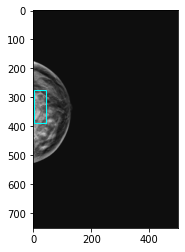

In [32]:
case_index   = 0#random.randint(0, len(valid_dataset))
img, all_target, _    = valid_dataset[case_index]
img          = img.astype('float32')
#img        = a.astype('float32')
#case_index = 0#random.randint(0, img.shape[0]-1)
#case_index = peaks[0]-5
plt.imshow(img[0], cmap='gray')
ax   = plt.gca()
case_index  = 0
print('slice location ', case_index, len(valid_dataset))

if 1:#len(all_target[case_index]) > 0 and all_scores[case_index][0] > 0.2:
    temp  = all_target['boxes'].data.cpu().numpy()#[case_index]
    print(temp)
    #print(case_index, all_scores[case_index])
    index = 0
    #rect  = patches.Rectangle((temp[0], temp[1]), temp[2]-temp[0], temp[3]-temp[1], linewidth=1, edgecolor='cyan', fill = False)
    rect  = patches.Rectangle((temp[index][0], temp[index][1]), temp[index][2]-temp[index][0], temp[index][3]-temp[index][1], linewidth=1, edgecolor='cyan', fill = False)
    ax.add_patch(rect)
else:
    print('Not found 8')

plt.show()
case_index = case_index+1

In [ ]:
# Validation Iteration #10 loss: 0.26083502173423767
# Validation Iteration #20 loss: 0.12475015223026276
# Validation Iteration #30 loss: 0.2311360090970993
# Validation Iteration #40 loss: 0.07870643585920334
# Validation Iteration #50 loss: 0.12904797494411469
# 0.17835015669465065

# Validation Iteration #10 loss: 0.16890683770179749
# Validation Iteration #20 loss: 0.12697485089302063
# Validation Iteration #30 loss: 0.202874094247818
# Validation Iteration #40 loss: 0.1275915801525116
# Validation Iteration #50 loss: 0.16607160866260529
# 0.17254152543842793

# Validation Iteration #10 loss: 0.14864173531532288
# Validation Iteration #20 loss: 0.13806253671646118
# Validation Iteration #30 loss: 0.13079851865768433
# Validation Iteration #40 loss: 0.09259304404258728
# Validation Iteration #50 loss: 0.13366109132766724
# 0.1608045955002308

# Validation Iteration #10 loss: 0.2190426141023636
# Validation Iteration #20 loss: 0.10993507504463196
# Validation Iteration #30 loss: 0.08774184435606003
# Validation Iteration #40 loss: 0.14777813851833344
# Validation Iteration #50 loss: 0.08807449787855148
# 0.1679838129878044

# fasterrcnn_resnet50_dbt22.pth
# Validation Iteration #10 loss: 0.12817245721817017
# Validation Iteration #20 loss: 0.3029731810092926
# Validation Iteration #30 loss: 0.06146375834941864
# Validation Iteration #40 loss: 0.08439958095550537
# Validation Iteration #50 loss: 0.059381939470767975
# 0.10177689090371132

In [ ]:
# [STAR] For doing inference of the model

all_target = []
all_scores = []

#device = torch.device("cpu")
#model.to(device)
model.load_state_dict(torch.load('fasterrcnn_resnet50_dbt22.pth'))
model.eval()



for images, targets, image_ids in valid_data_loader:
    new_images  = []
    for img in images:
        new_images.append(torch.Tensor(img).to(device))

    images    = new_images
    targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
    loss_dict = model(images)
    print(loss_dict)
    
    #print(loss_dict[0]['boxes'].data.cpu().numpy())
    
    all_scores.append(loss_dict[0]['scores'].data.cpu().numpy())
    all_target.append(loss_dict[0]['boxes'].data.cpu().numpy())

{'boxes': tensor([ 271, 1057,  805, 1490])}
Ground Truth  [ 271 1057  805 1490] 35
Prediction  [[ 75.71501  283.47375  163.6579   378.79547 ]
 [  4.241309 263.63602   50.325714 373.7304  ]
 [101.045715 287.99136  151.38869  370.79993 ]
 [ 61.922516 258.55548  184.89377  395.74182 ]]
Scores  [0.97706246 0.4141349  0.13911489 0.10131314]
Prediction  [[ 75.71501  283.47375  163.6579   378.79547 ]
 [  4.241309 263.63602   50.325714 373.7304  ]
 [101.045715 287.99136  151.38869  370.79993 ]
 [ 61.922516 258.55548  184.89377  395.74182 ]]
[ 67 264 201 372]


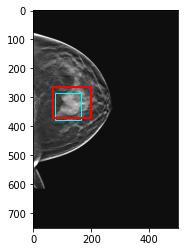

In [257]:
# [STAR] Code to compare the ground truth and predicted mask


case_index   = 35#random.randint(0, len(valid_dataset)-1)
images, b, c = valid_dataset[case_index]
print(b)

print('Ground Truth ', b['boxes'].data.cpu().numpy(), case_index)
print('Prediction ', all_target[case_index])
print('Scores ', all_scores[case_index])

plt.imshow(images[0], cmap='gray')
ax   = plt.gca()

# if(len(all_target1[case_index]) > 0):
#     #print(all_target1[index])
#     #print(all_scores1[index])
    
#     temp  = all_target1[case_index]
#     index = 0
#     rect  = patches.Rectangle((temp[index][0], temp[index][1]), temp[index][2]-temp[index][0], temp[index][3]-temp[index][1], linewidth=1, edgecolor='yellow', fill = False)
#     ax.add_patch(rect)
# else:
#     print('Not found 9')

if(len(all_target[case_index]) > 0):
    #print(all_target[index])
    #print(all_scores[index])
    
    temp  = all_target[case_index]
    print('Prediction ', temp)
    index = 0
    rect  = patches.Rectangle((temp[index][0], temp[index][1]), temp[index][2]-temp[index][0], temp[index][3]-temp[index][1], linewidth=1, edgecolor='cyan', fill = False)
    ax.add_patch(rect)
else:
    print('Not found 8')

temp  = b['boxes'].data.cpu().numpy()//4#all_target[index]
index = 0
print(temp)
rect  = patches.Rectangle((temp[0], temp[1]), temp[2]-temp[0], temp[3]-temp[1], linewidth=1, edgecolor='red', fill = False)
ax.add_patch(rect)


#rect = patches.Rectangle((0, 0), 500, 100, linewidth=2, edgecolor='cyan', fill = False)

plt.show()
case_index = case_index+1

In [ ]:
# Error cases for fasterrcnn_resnet50_dbt15.pth
Ground Truth  [[ 10.75 304.    51.25 333.75]] 5
Ground Truth  [[ 19.   416.25  63.5  447.75]] 6
Ground Truth  [[188.25 309.5  216.5  369.75]] 7
Ground Truth  [[193.25 389.5  228.   453.5 ]] 8
Ground Truth  [[463.75 150.5  498.5  222.75]] 14
Ground Truth  [[170.   335.25 195.5  362.25]] 23
Ground Truth  [[345.25 414.5  472.25 536.5 ]] 30
Ground Truth  [[451.5  333.75 496.   382.  ]] 34
Ground Truth  [[398.   166.75 468.25 222.  ]] 37
Ground Truth  [[317.75 332.75 388.75 394.  ]] 44
Ground Truth  [[  2.   273.25  44.   388.75]] 45
Ground Truth  [[5.0000e-01 3.9825e+02 6.1500e+01 5.1375e+02]] 46

# Error cases for fasterrcnn_resnet50_dbt14.pth
Ground Truth  [[188.25 309.5  216.5  369.75]] 7
Ground Truth  [[193.25 389.5  228.   453.5 ]] 8
Ground Truth  [[317.75 332.75 388.75 394.  ]] 44
Ground Truth  [[299.25 347.75 324.25 387.  ]] 48

In [9]:
dbtvol = np.fromfile('/media/drilnvm/ubuntudata2/TEST-DBT-RECONS/04140608-LE-L-CC_3000x1200x80.4_0.0005_-0.2_1_15.raw', dtype=np.float32)
dbtvol = np.reshape(dbtvol, [80, 1200, 3000])
print(dbtvol.shape)

(80, 1200, 3000)
